# Project 2 - TMA4215
<hr />

## Introduction
This project attempts to tackle Hamiltonian functions using machine learning. In particular, we implement a
machine learning algorithm based on the Adam algorithm and with a Stochastic Gradient Descent (SGD).
The algorithm is trained and tested on a set of given example functions, and thereafter trained with trajectories
for Hamiltonian systems. Using the trained weights, the model makes an attempt solving unknown trajectories.

Section 1 will cover the declarations and implementations of necessary functions for generating synthetic data.

Section 2 will implement the neutral network and training algorithm with the Adam method and SGD.
The section also covers testing of the trained network of the synthetic data and a comparison to the true values,
as well as training and testing the trajectory data.

Section 3 will first discuss how to calculate the gradient of a trained function, which is necessary for
the implementation of numerical integrators. Thereafter, the two numerical integrators known as
the symplectic Euler method and Størmer-Verlet method, are implemented for both known and unknown hamiltonians.

We start off by importing necessary libraries and data. Note that the trajectories used through the entire project, is the new trajectory data.

In [1]:
# Imports
import numpy as np #NumPy library for numerical computation in Python
import matplotlib.pyplot as plt # Main plotting package

# Necessary for surface plotting ______
from matplotlib import cm # Color maps
from matplotlib import colors 
from mpl_toolkits.mplot3d import Axes3D
# _____________________________________

import intervals as interval # Used for defining domains of closed intervals 
import sys # For printing and flushing
import time # Receive current time to calculate expected remaining time
%matplotlib notebook 
import project_2_data_acquisition as dataFile # The given .ipynb for importing trajectory data, converted to .py

## Section 1 - Generating synthetic data 
The following code defines the class infrastructure used in order to generate synthetic data from the given
example functions. We also define a scaler class used to scale data, a helpful tool
when implementing machine learning.

Furthermore, we define `f1`, `f2`, `f3` and `f4` as function objects based on $F(y)$
from the table at page 6 of the project description.

In [2]:

class domain:
    '''
    This class allows us to define multi-dimensional domains, and is used
    for the example data generating functions.
    The domain class is also used for the known hamiltonians in section 4.
    
    dim       : dimention, d in the table
    intervals : intervals as described in table
    excluded  : potential points excluded from domain, e.g. (0,0) for last function from table
    '''
    def __init__(self, intrvals):
        self.dim = len(intrvals)
        self.intervals = intrvals
        self.excluded = [interval.empty() for i in range(self.dim)]
        
    def __contains__(self, item):
        '''
        Overloads the *in* operator, i.e. checks if item is in self
        '''
        if np.isscalar(item):
            if self.dim != 1: return False
            return item in self.intervals[0]
        
        if len(item) != self.dim: return False
        contains = True
        notInExcluded = False
        for i in range(self.dim):
            contains *= (item[i] in self.intervals[i])
            notInExcluded += (item[i] not in self.excluded[i])    
        contains *= (notInExcluded > 0)
        return contains

    def __sub__(self, dom_to_remove):
        '''
        Remove subdomains from a domain.
        This opens for a much simpler notation when setting domains, e.g.
        domain(interval.closed(-1,1) - interval.closed(-0.1, 0.1)) for [-1,1]\[-0.1,0.1]
        '''
        if dom_to_remove.dim != self.dim:
            raise Exception("Error: Domain dimension mismatch in subtract")
        new_dom = domain(self.intervals)
        for i in range(self.dim):
            new_dom.excluded[i] = dom_to_remove.intervals[i]

        if new_dom.intervals == new_dom.excluded:
            return domain([intervals.empty() for i in range(new_dom.dim)])
        return new_dom

    def drawRandom(self, n):
        '''
        Draw n random samples from within the domain, with a uniform probability distribution
        '''
        samples = []
        while len(samples) < n:
            sample = [np.random.uniform(self.intervals[k].lower, self.intervals[k].upper) for k in range(self.dim)]
            if sample in self:
                samples.append(sample)
        
        return np.array(samples).T

    def drawGrid(self, shape):
        '''
        Draw a grid of samples from the domain

        shape : shape of the grid (tuple(d0))

        -Note- these points might be in the excluded domain
        '''
        linspaces = tuple([np.linspace(self.intervals[k].lower, self.intervals[k].upper, shape[k]) for k in range(self.dim)])

        return linspaces
            

class datGenFunctions:
    '''
    Class of example functions for generating data, as well as for known hamiltonians

    d0  : input dimension
    d   : hidden layer dimension, usually 2*d0
    F   : function F(y), implemented inline with anonymous lambda functions
    dom : domain (domain object)
    '''
    def __init__(self, d0, d, F, dom):
        self.d0 = d0
        self.d = d
        self.F = F
        self.dom = dom

    def __call__(self, *y):
        '''
        Calls the function, and throws exception if y is outside of domain

        returns : F(y)
        '''
        if np.isscalar(y) or np.isscalar(y[0]):
            if not y in self.dom:
                raise Exception("Error: y = "+str(y)+" outside of function domain")
            
        else: 
            yy = np.array(y)
            if not np.isscalar(y[0][0]):
                shape = list(yy.shape)
                yy = np.reshape(yy, (shape[0], np.product(shape[1:])))
            for row in yy.T:
                if not row in self.dom:
                    raise Exception("Error: y = "+str(row)+" outside of function domain")

        return self.F(*y)
            


class scaler:
    '''
    This class stores the scale parameters, so that a rescaling can be performed easily

    ci             : data to scale
    [alpha, beta]  : range to scale the data into
    '''
    def __init__(self, ci, alpha=0.2, beta=0.8):
        # Store the scale parameters
        self.a = np.amin(ci)
        self.b = np.amax(ci)
        self.alpha = alpha
        self.beta = beta
        self.scalefunc = (lambda c : 1/(self.b-self.a)*((self.b-c)*self.alpha+(c-self.a)*self.beta))
        '''
        scalefunc scales data using min-max method as described on page 6 of the Project description.
        '''

    def scale(self, ci):
        '''Scale data'''
        return self.scalefunc(ci)

    def rescale(self, ci):
        '''
        Rescale data, the inverse function of scale
        '''
        return (self.a - self.b)/(self.alpha - self.beta) * ci + (self.alpha*self.b - self.a*self.beta)/(self.alpha - self.beta)

    def gradientRescale(self, ci):
        '''
        Rescaler needed for rescaling the gradient, 
        this is the same as inverse of scalefunc but without shifting of c
        '''
        return (self.a - self.b)/(self.alpha - self.beta) * ci



def genData(funcObj, numInput=250):
    '''
    Generates random data within domain from given function
    '''
    y = funcObj.dom.drawRandom(numInput)
    c = funcObj(*tuple(y))
    sc_c = scaler(c)
    sc_y = scaler(y)
    return sc_c, y, sc_c.scale(c)




## Section 2 - Implementation of neural network
### 2.1 - Foundations and infrastructure
We start by defining necessary functions as given in the project description - that is
$$
\eta(x),\quad \eta'(x),\quad \sigma(x), \quad \sigma'(x), \quad \tilde{F}(Z_k, \omega, \mu, n),\quad \frac{\partial J}{\partial \mu},\quad \frac{\partial J}{\partial \omega}, 
$$
An additional `embed`-function is defined, in order to fit the data points from a function of dimension $d_0$ to have shape $d$.

We chose $\eta(x) = \frac{1}{2} (1 + tanh(\frac{x}{2}))$ as the hypothesis function, simply beacuse it gave us the most
consistent results. Especially the unknown hamiltonian proved to be more prone to divergence when using the identity function as
hypothesis function.

In [3]:
def eta(x):
    '''
    Hypothesis function
    '''
    return 0.5*(1+np.tanh(x/2)) # Alternative definition of eta(x)
    #return x 


def eta_derivative(x):
    '''
    Derivative of hypothesis function
    '''
    return (1/4)*(1-np.square(np.tanh(x/2))) #Follows from alternative definition of eta(x)
    #return np.ones(x.shape)


def F_tilde(Z_k, omega, mu, n_samples):
    return eta(np.transpose(Z_k)@omega+mu*np.ones((n_samples, 1)))


def P_k(omega, Z_k, mu, c, n_samples):
    ypsilon = eta(Z_k.T@omega + mu*np.ones((Z_k.T@omega).shape))
    return np.outer(omega, ((ypsilon-c)*eta_derivative(Z_k.T@omega + mu*np.ones((Z_k.T@omega).shape))).T)


def dJdMu(Z_k, omega, mu, c, n_samples):
    z_minus_c = F_tilde(Z_k, omega, mu, n_samples)-c
    eta_arg = (np.transpose(Z_k)@omega + mu*np.ones((n_samples, 1))).T
    return eta_derivative(eta_arg)@z_minus_c


def dJdOmega(Z_k, omega, mu, c, n_samples):
    return Z_k@((F_tilde(Z_k, omega, mu, n_samples)-c)*eta_derivative(np.transpose(Z_k)@omega + mu))


def sigma(x):
    '''Sigmoid activation function'''
    return np.tanh(x)

def sigmaDerivative(x):
    '''Derivative of activation function'''
    return 1-np.square(np.tanh(x))


def Z_k(Z_k_minus_1, h, W_k_minus_1, b_k_minus_1):
    return Z_k_minus_1 + h*np.tanh(W_k_minus_1@Z_k_minus_1 + b_k_minus_1)


def P_k_minus_1(P_k, h, W_k, Z_k_minus_1, b_k):
    return P_k + h*np.transpose(W_k)@(sigmaDerivative(W_k@Z_k_minus_1 + b_k)*P_k)


def embed(y, d):
    '''This functions embeds the input data in R^d, by setting all extra coordinates to 0'''
    y = np.array(y)
    return np.concatenate((y, np.zeros((d-y.shape[0],y.shape[1]))))



### 2.2 - Network class and training implementation
The `network` class is the main class for storing information about a neural network.
The class stores all learning parameters, parameters for Adam descent and defines the member functions
`train`, `showConvergence`, `getParams`, `checkTraining`, `grad`, along with some helper functions
(see docstring in the code). The addition operator is also overloaded so that one can sum two networks, e.g. $T$ and $V$.


The `train`-function contains an implementation of the Adam-algorithm and an option for Stochastic Gradient Descent (SGD),
i.e, an optional input parameter for some $\bar{I} \ll I$ that chooses a different subset of $(y_i)_{i=1}^{\bar{I}}$
points for each iteration, instead of all $(y_i)$.

`showConvergence` draws the residue plots, i.e. $J/I$ over each time step.
`getParams` returns the trained parameters and is only used for initializing the tester class,
which is explained further on.
`checkTraining` simply confirms that a network has trained, and runs before testing a netowrk.
`grad` is the implementation of the gradient of trained function, that is $\nabla_y F(y))$.
See *Section 3* for a detailed discussion of reaching this result.

In [4]:
class network:
    '''
    Network class - main class for storing values and weights.
    Init Parameters:
        K  : Number of layers (int)
        h  : Step length (float)
        tau: Learning parameter (float)
        d  : Number of dimensions for each layer (int)
        d0 : Number of dimensions in input layer (int)
        iterations : number of iterations (int)
        hasTrained : toggles when training is done (bool)
    We also define necessary parameters for Adam descent method;
    these values are universal for all network objects.
    '''
    def __init__(self, K, h, tau, d, d0, iterations):
        self.K = K
        self.h = h
        self.tau = tau
        self.d = d
        self.d0 = d0
        self.iterations = iterations
        self.hasTrained = False

        # Params for Adam descent
        self.m = [0, 0, 0, 0]
        self.v = [0, 0, 0, 0]
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.alpha = 0.01
        self.epsilon = 1e-8       
         
    def train(self, y, c, I_bar=False):
        '''
        Input: y-values, c-values I_bar (optional) - last one for stochastic gradient descent
        This function trains the network like described in the psudeocode of the Adam-method,
        and in addition has an optional implementation of stochastic gradient descent.
        Toggles the hasTrained bool/flag to True and saves trained weights when completed.
        '''
        if not I_bar:
            I_bar = len(c)

        n_samples = len(c)
        
        b = np.random.randn(self.K, self.d, 1)
        W = np.random.randn(self.K, self.d, self.d)
        mu = np.random.rand()
        omega = np.random.randn(self.d,1)

        Z = np.zeros((self.K+1, self.d, n_samples))
        Z[0] = np.array(embed(y, self.d)[:, :n_samples])
        c = np.expand_dims(c[:n_samples], axis=1)

        J = []
        dJdW = np.zeros((self.K, self.d, self.d))
        dJdb = np.zeros((self.K, self.d, 1))
        J_grad = [dJdW, dJdb, 0, 0]
        U = [W, b, mu, omega]

        startTime = time.time() # Starting a timer for keeping track of training progress

        sys.stdout.write("Training")
        sys.stdout.flush()
        for n in range(1, self.iterations+1):
            sys.stdout.write("\rTraining: " + str(round(n/self.iterations*100, 1)) + "%   Estimated time remaining: " + str(round((time.time()-startTime)*self.iterations/n - (time.time()-startTime))) + " seconds        ")
            sys.stdout.flush()
            


            #Clearing the list of P's from the previous iteration
            P = np.zeros((self.K, self.d, n_samples))

            #Running the images through all layers
            for k in range(1, self.K+1):
                Z[k] = Z_k(Z[k-1], self.h, U[0][k-1], U[1][k-1])
            
            
            #Finding P for the last layer
            P[-1] = P_k(U[3], Z[-1], U[2], c, n_samples)
            
            #Stochastic gradient decent - choose random indices
            if I_bar:
                selected = np.random.default_rng().choice(n_samples, I_bar, replace=False)
            else:
                selected = np.arange(n_samples)

            
            
            #Computing the contributions to grad(U) by mu and w
            subZet = np.array([Z[self.K][:,i] for i in selected]).T #Pot. subset Z with indices according to SGD
            subCet = np.array([c[i] for i in selected]) #like subZet with c
            J_grad[2] = dJdMu(subZet, U[3], U[2], subCet, I_bar)
            J_grad[3] = dJdOmega(subZet, U[3], U[2], subCet, I_bar)
            
            
            #Backpropagating; finding P for all layers
            for k in range(self.K-1, 0, -1):
                P[k-1] = P_k_minus_1(P[k], self.h, U[0][k], Z[k-1], U[1][k])

                
            #Calculating the contributions to grad(U) by W and b
            for k in range(self.K):
                sigmaArg = U[0][k]@Z[k] + U[1][k]
                brackets = P[k]*sigmaDerivative(sigmaArg)
                J_grad[0][k] = self.h*(np.array([brackets[:, i] for i in selected]).T@np.transpose(subZet))
                J_grad[1][k] = self.h*np.array([brackets[:, i] for i in selected]).T@np.ones((I_bar, 1))
            
            
            #Adam descent:
            for i in range(len(J_grad)):
                self.m[i] = self.beta_1 * self.m[i] + (1-self.beta_1) * J_grad[i]
                self.v[i] = self.beta_2 * self.v[i] + (1-self.beta_2) * np.square(J_grad[i])
                m_hat = self.m[i] / (1-self.beta_1**(n))
                v_hat = self.v[i] / (1-self.beta_2**(n))
                U[i] = U[i] - self.alpha*(m_hat/(np.sqrt(v_hat)+self.epsilon))
            
            
            #Finding approximation 
            Ypsilon = F_tilde(Z[self.K], U[3], U[2], n_samples)
            
            #Computing the average error
            J.append(0.5*np.linalg.norm(Ypsilon - c)**2*(1/n_samples))
        
        #---------------------------------------------------------------------------    

        
        sys.stdout.write("\r\rTraining: Done     Runtime: " + str(round((time.time() - startTime), 2)) + " seconds                    \n")
        
        self.W = U[0]
        self.b = U[1]
        self.mu = U[2]
        self.omega = U[3]
        self.J = J
        self.hasTrained = True

    def showConvergence(self, axs, plotType):
        '''
        Draws the residue plot, i.e. J/I over each iteration.
        plotType : {log, lin}, option to either log-plot or lin-plot (string)          
        '''
        self.checkTraining()

        axs.plot(self.J)
        axs.yaxis.set_label_coords(-0.1,1.02)
        axs.set_title("Residue plot")
        axs.set_ylabel(r"$J/I$", rotation="horizontal", size="large")
        axs.set_xlabel("Training iteration")
        axs.set_yscale(plotType)
        plt.show()

    def getParams(self):
        '''Returns trained parameters'''
        self.checkTraining()
        return self.W, self.b, self.mu, self.omega


    def checkTraining(self):
        '''Ensures that only trained networks can be tested.'''
        if not self.hasTrained:
            raise Exception("Error, neural network has not been trained")

    def propagate(self, y):
        '''
        Propagate y through the network

        returns : all Z and the output of the network
        '''
        self.checkTraining()
        
        z = []
        z.append(embed(np.array(y), self.d))
        for k in range(self.K):
            z.append(z[-1] + self.h*sigma(self.W[k]@(z[-1]) + self.b[k]))
        f_tilde = eta((z[-1]).T@self.omega + self.mu)
        return z, f_tilde

    def grad(self, y):
        '''
        Compute the gradient of the neural network at y

        y : point to compute the gradient

        returns : first d0 elements of gradient at point y
        '''
        Z_list, f_tilde = self.propagate(y)
 
        A = eta_derivative((np.dot(np.squeeze(self.omega), np.squeeze(Z_list[-1])) + self.mu))*self.omega 
        for k in range(self.K, 0, -1):
            A = A + np.transpose(self.W[k-1, :])@(self.h*sigmaDerivative(self.W[k-1, :]@Z_list[k-1] + self.b[k-1]) * A)
        return np.squeeze(A)[:self.d0]

    def gradSum(self, other, p, q):
        '''
        Take the gradient of a sum of neural networks, analogous to grad(T+V)
        '''
        gradT = self.grad(p)
        gradV = other.grad(q)
        return gradT + gradV

    def __add__(self, other):
        '''
        This allows us to effectively add to neural networks
        by propagating through each of them and adding the result

        Note: Only works with T + V, will not work with V + T
        '''
        def call(p, q):
            _, T_tilde = self.propagate(p)
            _, V_tilde = other.propagate(q)
            return T_tilde + V_tilde
        
        return call

        

### 2.3 - Tester class and plotting
The tester class takes a trained neutral network, as well as testing data
(input parameters `y` and `c`) and compares these.
The class has two member functions, `plot` and `trajectoryPlotter`, where `plot`
compares the test data and the network approximation of said data. Similarly, `trajectoryPlotter`
is adapted to plot the trajectories from the test data and the network approximation.
See docstrings and inline comments in the code below for plotting details.

In [5]:
class tester:
    '''
    This class can run various tests on the trained neural network.

    y        : Input data to test (numpy ndarray)
    c        : Analytic result of y; F(y) (numpy ndarray)
    sc       : The scaler used to scale c in the training phase (scaler object)
    nn       : The neural network to test (network object)
    funcObj  : The function object that the network is trained on (datGenFunction object)
    plotType : {'log', 'lin'} The y-scale of the convergence plot. Default: 'log'
    grid     : The grid to plot 3D surfaces on, if applicable (tuple)
    '''
    def __init__(self, y, c, sc, nn, funcObj, plotType="log", grid = None):
        if nn.d0 == 1:
            self.fig, self.axs = plt.subplots(2, 1)
        else:
            self.fig, self.axs = plt.subplots(1)
            self.axs = [self.axs]
        
        # Plot the convergence of J from the training
        nn.showConvergence(self.axs[0], plotType)
        print("Last J from training: ", nn.J[-1])
        
        # Get obtained parameters from training
        W, b, mu, omega = nn.getParams()

        self.y = np.squeeze(y)

        if nn.d0 < 3:
            # This line is only needed when we want to plot, hence disabled for d0 >= 3
            y = np.reshape(np.array(np.meshgrid(*y)), (nn.d//2,len(y[-1])**(nn.d//2)))


        # Propagate through network
        z, f_tilde = nn.propagate(y)

        # Rescale using the same scaler as the data was scaled with
        f_tilde = sc.rescale(f_tilde) 

        # Write data to class attributes
        self.c = c
        self.f_tilde = f_tilde
        self.d = nn.d
        self.d0 = nn.d0
        self.network = nn
        self.grid = grid
        self.funcObj = funcObj
        self.sc = sc

    def plot(self):
        '''
        Main function for preforming test plots.
        for d0==1, simply plots c(y) for analytical and approximated values.
        '''
        if self.d0 == 1:
            # Plot a comparison between the analytical and the neural network approximation
            self.axs[1].plot(self.y, self.c, label="Analytical")
            self.axs[1].plot(self.y, self.f_tilde, label="Neural network approx.")
            self.fig.legend()
            plt.show()

        
        elif self.d0 == 2:
            '''
            In this case, the function plots three 3D surfaces, the first one being the anlytical graph,
            the second being the neural network approximation, and the third being the difference between them
            '''

            # Set up a grid of y-values
            if self.grid != None:
                y1 , y2 = np.linspace(min(self.y[0]), max(self.y[0]), grid[0]), np.linspace(min(self.y[1]), max(self.y[1]), grid[1])
                y1, y2 = np.meshgrid(y1, y2)
            else:
                y1, y2 = np.meshgrid(self.y[0], self.y[1])

            self.c = self.funcObj(y1, y2)

            self.f_tilde = np.reshape(self.f_tilde, self.grid)


            # Make a figure
            fig = plt.figure()
            
            fig.suptitle("Test results")
            
            # Containers for surfaces and axes
            surfaces = []
            axs = []

            # ------- First plot ------
            # Add the first subplot to the figure
            axs.append(fig.add_subplot(3, 1, 1, projection="3d"))
            
            # Plot the first surface
            surfaces.append(axs[0].plot_surface(y1, y2, self.c, cmap=cm.Spectral,
                                linewidth=0, antialiased=False))

            # Set title
            axs[0].set_title("Analytic")

            # Add a colorbar
            #fig.colorbar(surf1, shrink=0.5, aspect=5)


            # ------- Second plot ------
            # Add the first subplot to the figure
            axs.append(fig.add_subplot(3, 1, 2, projection="3d"))
            
            # Plot a normal vector to the surface at a random point
            randomIndex = np.random.randint(len(y1.flatten()))
            x = y1.flatten()[randomIndex]
            y = y2.flatten()[randomIndex]
            z = self.f_tilde.flatten()[randomIndex]
            axs[1].quiver(x,y,z,*tuple(self.sc.gradientRescale(self.network.grad([[x], [y]]))),-1, 
                          label="Normal vector at\n" + str(np.around([x, y, z], 2)))

            # Plot the second surface
            surfaces.append(axs[1].plot_surface(y1, y2, self.f_tilde, cmap=cm.Spectral,
                                linewidth=0, antialiased=False))
            
            fig.legend()
            
            # Set title
            axs[1].set_title("Neural network approx.")

            # Find max and min value across the two first surfaces, for mapping colors
            vmin = min(surface.get_array().min() for surface in surfaces)
            vmax = max(surface.get_array().max() for surface in surfaces)
            norm = colors.Normalize(vmin=vmin, vmax=vmax)
            for sf in surfaces:
                sf.set_norm(norm)
            
            # Add colorbar, this will be shared for the first two surfaces
            fig.colorbar(surfaces[0], ax=axs, orientation='vertical')


            # ------- Third plot -------
            # Add the third subplot
            ax = fig.add_subplot(3, 1, 3, projection="3d")

            # Plot the surface
            surf3 = ax.plot_surface(y1, y2, np.absolute((self.f_tilde-self.c)/self.c.max()), cmap=cm.coolwarm,
                                linewidth=0, antialiased=False)

            # Set title
            ax.set_title("Relative difference")            

            # Add colorbar, the last surface gets its own colorbar
            fig.colorbar(surf3, shrink=0.5, aspect=5)

            plt.show()
        
        # Print J for the test data
        print("J for test data:", 0.5*np.linalg.norm(np.squeeze(self.f_tilde)-self.c)**2/np.prod(self.f_tilde.shape))

            
    def trajectoryPlotter(self, axs, ylabel):
        '''
        Additional function for plotting trajectory data
        '''
        axs.plot(self.c, label="Trajectory data")
        axs.plot(self.f_tilde, label="Neural network prediction")
        axs.set_xlabel("Time step")
        axs.set_ylabel(ylabel)
        axs.legend()
        plt.show()

        # Print J for the test data
        print("J for test data: ", 0.5*np.linalg.norm(np.squeeze(self.f_tilde)-self.c)**2/np.prod(self.f_tilde.shape))




### 2.4 - Optimal choices for network parameters
Through systematic testing, we have found that the best results we can expect to get, is around $J = 10^-4$ for the
error during training, and $J = 10^-3$ for new generated test data. Our optimization of the training parameters
will therefore have as a goal to achieve these results relatively consistently without unnecessary high amount
of computation time.

* $K$: By testing the network for different parameter values, we have found that $K=30$ layers
will be sufficient without too great error. Although the error decreases by choosing $K>30$,
the impact of the additional layers will not justify the increase in computation time.
* $d$: For a function $F$ with input dimension $d_0$, we get a sufficiently small $J$ by setting the dimension of each hidden layer, $d=2d_0$. This seems to apply universally.
* $h$: The parameter $h$ affect how "much impact" one layer has. We find $h=0.1$ to be sufficient for functions whose dimensions are $1$, $d_0=1$.
    * For cases where $d_0>1$, the value of $0.1$ is too great and negatively affects the results. Thus, we use $h=0.01$ for functions whose $d_0>1$.
* $\tau$: The learning parameter $\tau$ impacts the speed of convergence. Similarly to the parameter $h$, we found that $\tau = 0.002$
seems to be a good value with reasonable convergence speed, given $d_0(F(y))=1$.
    * However, where $d_0>1$, $\tau$ is set to $0.001$. 
* Number of iterations: $600$ iterations will be enough in most cases. For more complex functions, $1,000$ iterations have had been necessary.

The final parameter to choose is the number of generated data points in testing phase, $I$.
Using too many points will affect the computation time greatly. However, using too few points might result in overfitting.
One thing to keep in mind when choosing this value, is that training the network is essentially analogous to solving a system
with $K \cdot d^2 + K \cdot d + 2$ unknowns and $I$ equations. Hence, as a rule of thumb, we want to use at least $I = K \cdot d^2 + K \cdot d + 2$.
We therefore landed on $I \approx 2 \cdot K \cdot d^2$.

### 2.5 - Preforming tests of trained networks

#### 2.5.1 - Testing synthetic functions
We restate the given example functions for generating synthetic data:
$$
\begin{array}{c|cccc}
 & d_0 & d & F(y) & \text{Domain}\\[6pt]
F_1(y) & 1 & 2 & \frac12 y^2 & [-2,2] \\[6pt]
F_2(y) & 1 & 2 & 1-\cos y & [-\frac{\pi}{3},\frac{\pi}{3}] \\[6pt]
F_3(y) & 2 & 4 & \frac12 (y_1^2+y_2^2) & [-2,2]\times[-2,2] \\[6pt]
F_4(y) & 2 & 4 & -\frac{1}{\sqrt{y_1^2+y_2^2}}  & \mathbb{R}^2\backslash \{0,0\} \\
\end{array}
$$
Note: for $F_4$ we set the domain to be $[-10, 10]\backslash [-\frac12,\frac12] $,
as it's infeasible to simulate the entire real plane.

All example functions are implemented below as $F_i(y)=\tt{fi}$.
The cells below output a log-plot of the residue during the training of the network, and a plot of
analytical $F_i(y)$ compared with the neural network approximation $\tilde{F}(y; \theta)$ against new testpoints $y$.

In [6]:
dom1 = domain([interval.closed(-2, 2)])
f1 = datGenFunctions(1, 2, lambda y : 0.5*y**2, dom1)

dom2 = domain([interval.closed(-np.pi/3, np.pi/3)])
f2 = datGenFunctions(1, 2, lambda y : 1-np.cos(y), dom2)

dom3 = domain([interval.closed(-2, 2), interval.closed(-2, 2)])
f3 = datGenFunctions(2, 4, lambda y1,y2 : 0.5*(y1**2+y2**2), dom3)

xy_plane = domain([interval.closed(-10, 10), interval.closed(-10, 10)]) #[-10, 10]x[-10, 10] set as the entire xy plane
zero = domain([interval.closed(-0.5,0.5), interval.closed(-0.5,0.5)])
dom4 = xy_plane - zero
f4 = datGenFunctions(2, 4, lambda y1,y2 : -1*1/np.sqrt(y1**2+y2**2), dom4)

Training: Done     Runtime: 4.41 seconds                      


<IPython.core.display.Javascript object>


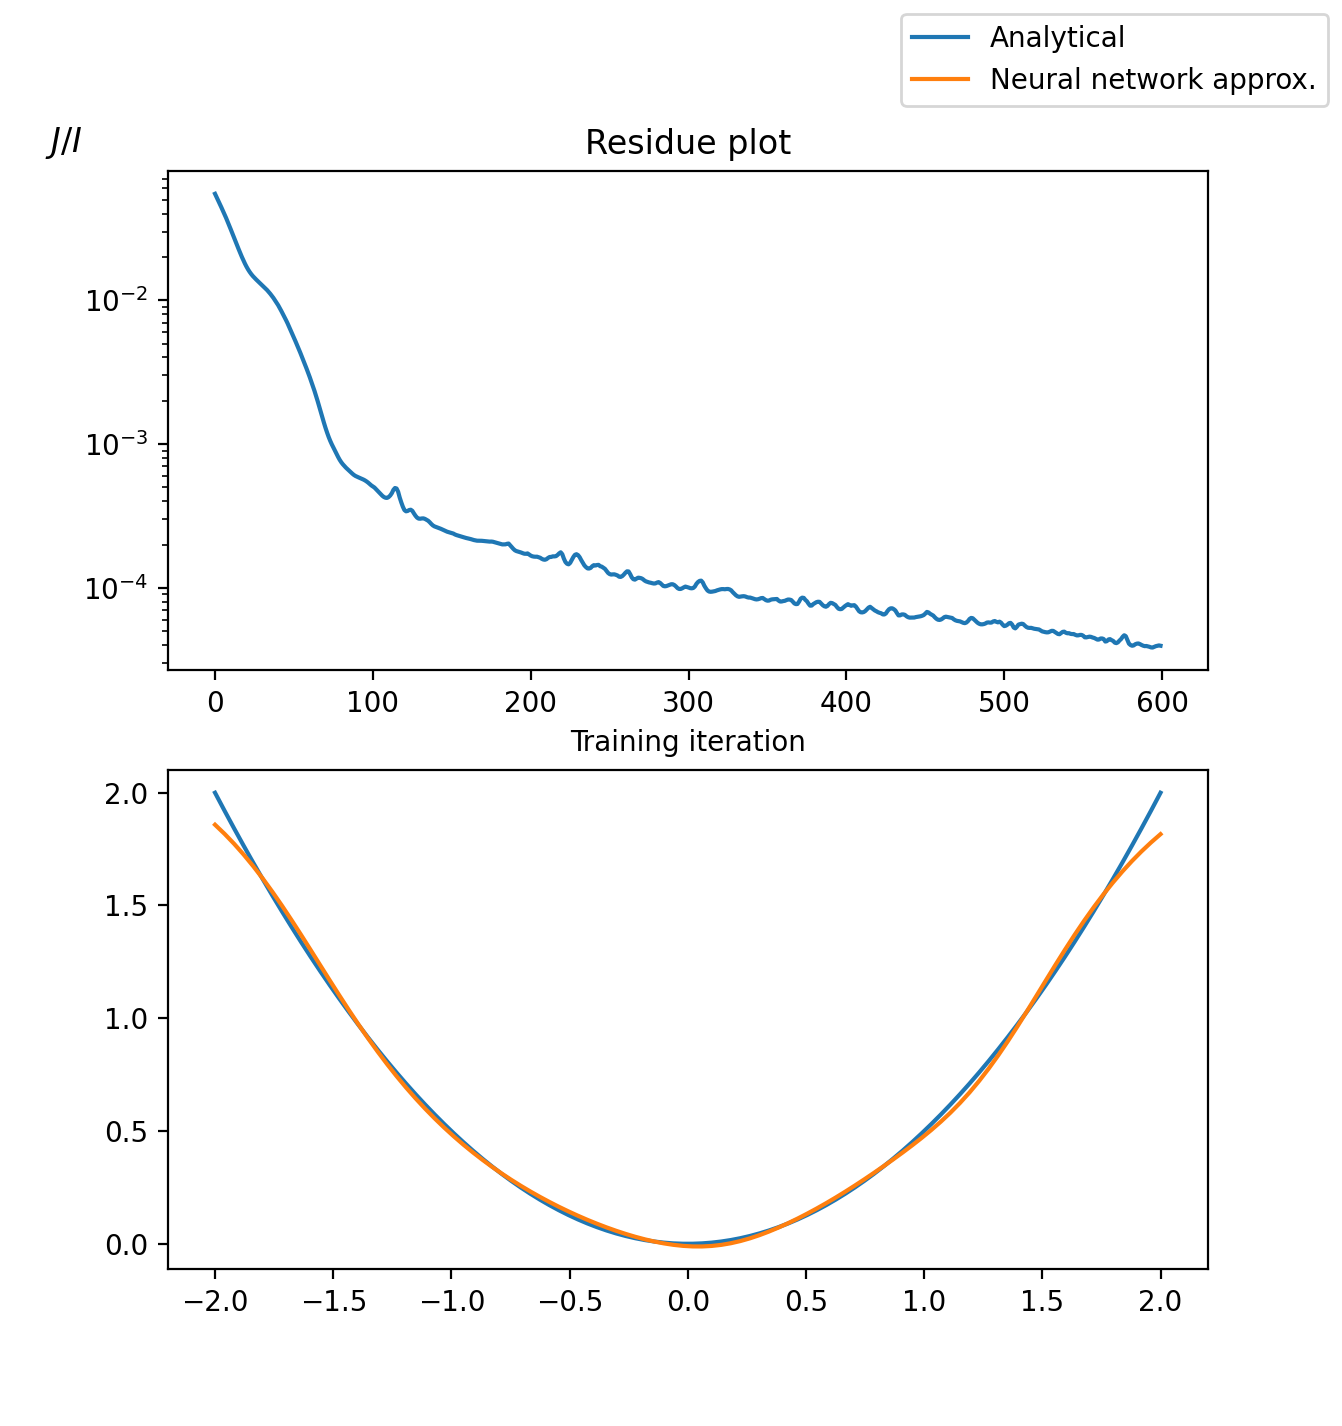

Last J from training:  3.952400791439993e-05
J for test data: 0.0006689622141397997


In [22]:
#__________ f1(y) __________
sc1, y1, c1 = genData(f1, 200)

nn1 = network(K = 30, 
            tau = 0.002,
            h = 0.1,
            d = 2,
            d0 = 1,
            iterations = 600
            )


nn1.train(y1, c1, 20)
y1 = np.linspace(-2, 2, 100)
c1 = f1(y1)
test1 = tester([y1], c1, sc1, nn1, f1)
test1.plot()


**Remarks to $F_1(y)$:** $J/I$ decreases most dramatically around the first $200$ iterations,
and continues decreasing close to linearly for increasing iterations.
Both the analytical and approximated values share the same shape and closely resemble the same values.
However, for the boundry points, $y\approx \pm1.8$, the differences are more evident.

A final remark is that $J$ from the training is of order $10^{-5}$, whereas $J$ from testing is of order $10^{-4}$.
Upon review, a differnce of factor $\approx 10$ as is the case here, does not necessarily consittute overfitting.

Training: Done     Runtime: 4.54 seconds                      


<IPython.core.display.Javascript object>


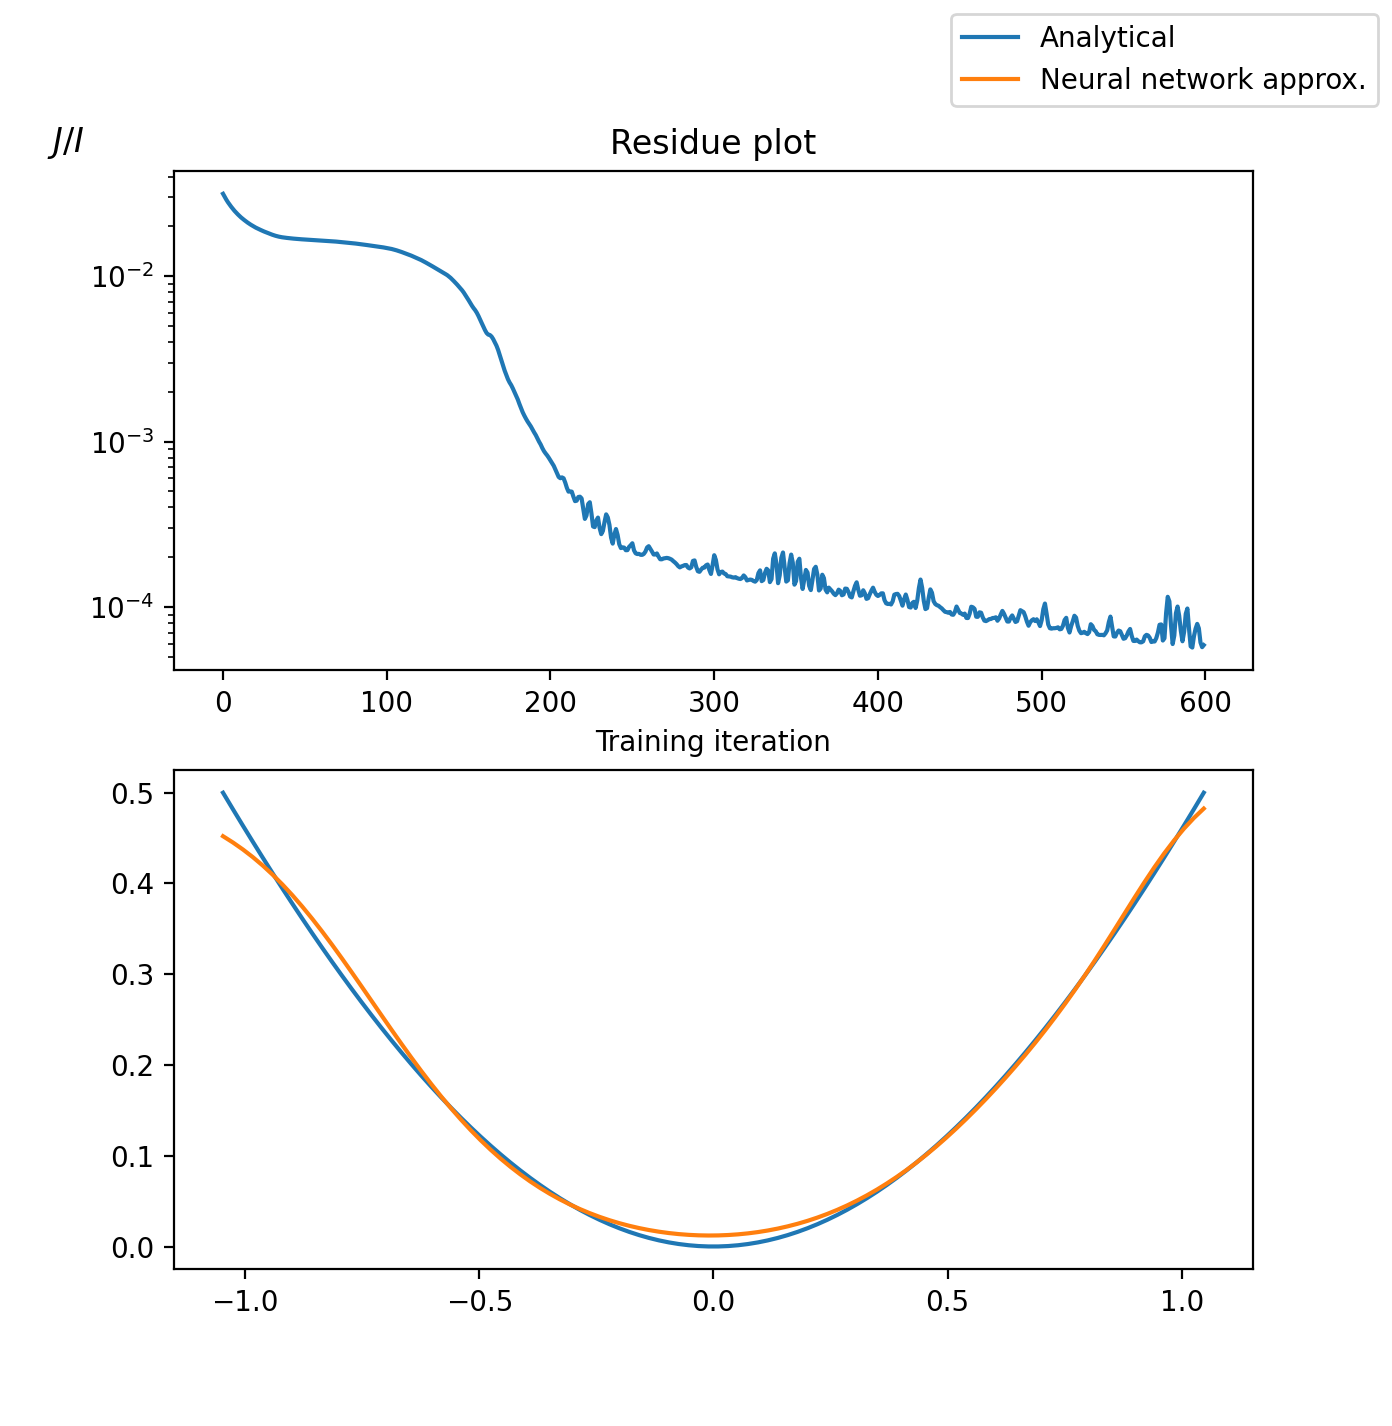

Last J from training:  5.885117266078403e-05
J for test data: 5.4024776945141805e-05


In [23]:
#__________ f2(y) __________
sc2, y2, c2 = genData(f2, 200)

nn2 = network(K = 30, 
            tau = 0.002,
            h = 0.1,
            d = 2,
            d0 = 1,
            iterations = 600
            )

nn2.train(y2, c2, 20)
y2 = np.linspace(-np.pi/3, np.pi/3, 100)
c2 = f2(y2)
test2 = tester([y2], c2, sc2, nn2, f2)
test2.plot()

**Remarks to $F_2(y)$** The residue plot has a similar behavior to that of $F_1(y)$, except for a somewhat
jagged pattern around the later iterations. Increasing $\tau$ seem to dim the severity of these artifacts.

Furthermore, the network approximates $F_2(y)$ to a great prescision, with $J$ being of order $10^{-6}$ for both training and testing.
The comparison plot also highlights the similarities between analytical and approximation. 

In [24]:
#__________ f3(y) __________
sc3, y3, c3 = genData(f3, 800)


nn3 = network(K = 30, 
            tau = 0.001,
            h = 0.01,
            d = 4,
            d0 = 2,
            iterations = 1000
            )

nn3.train(y3, c3, 20)

Training: Done     Runtime: 16.28 seconds                     


<IPython.core.display.Javascript object>


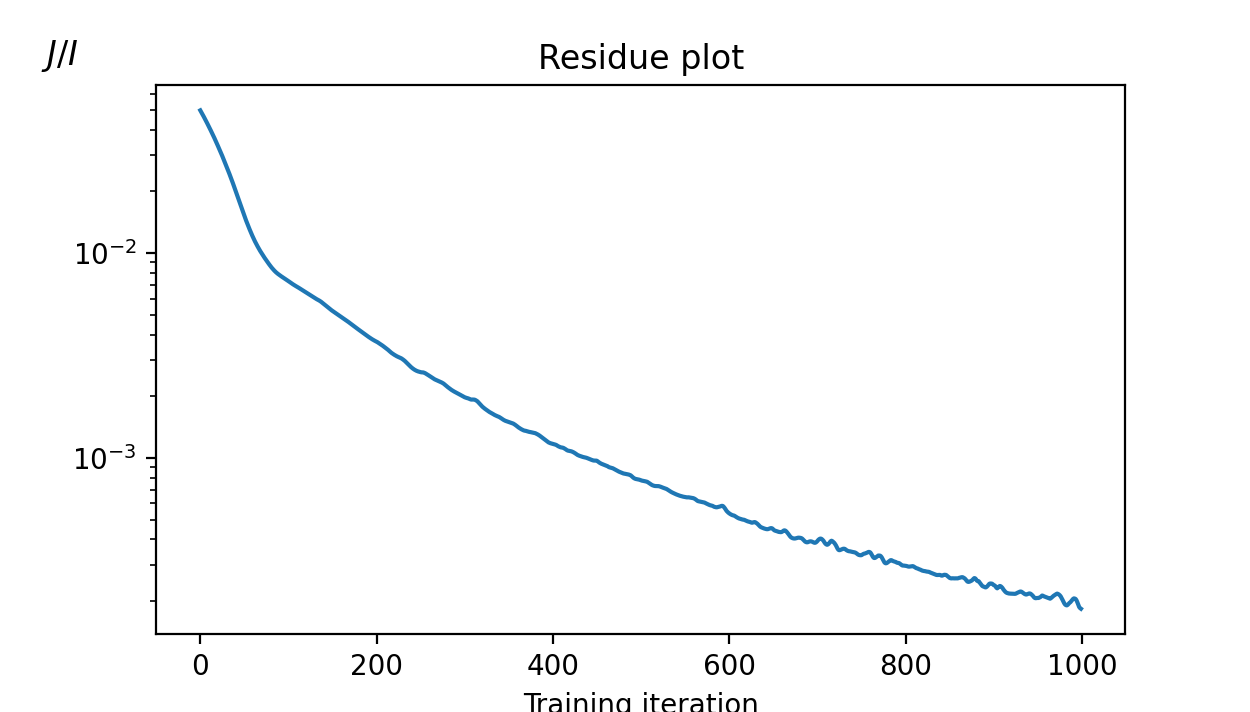

Last J from training:  0.00018357389546201877


<IPython.core.display.Javascript object>


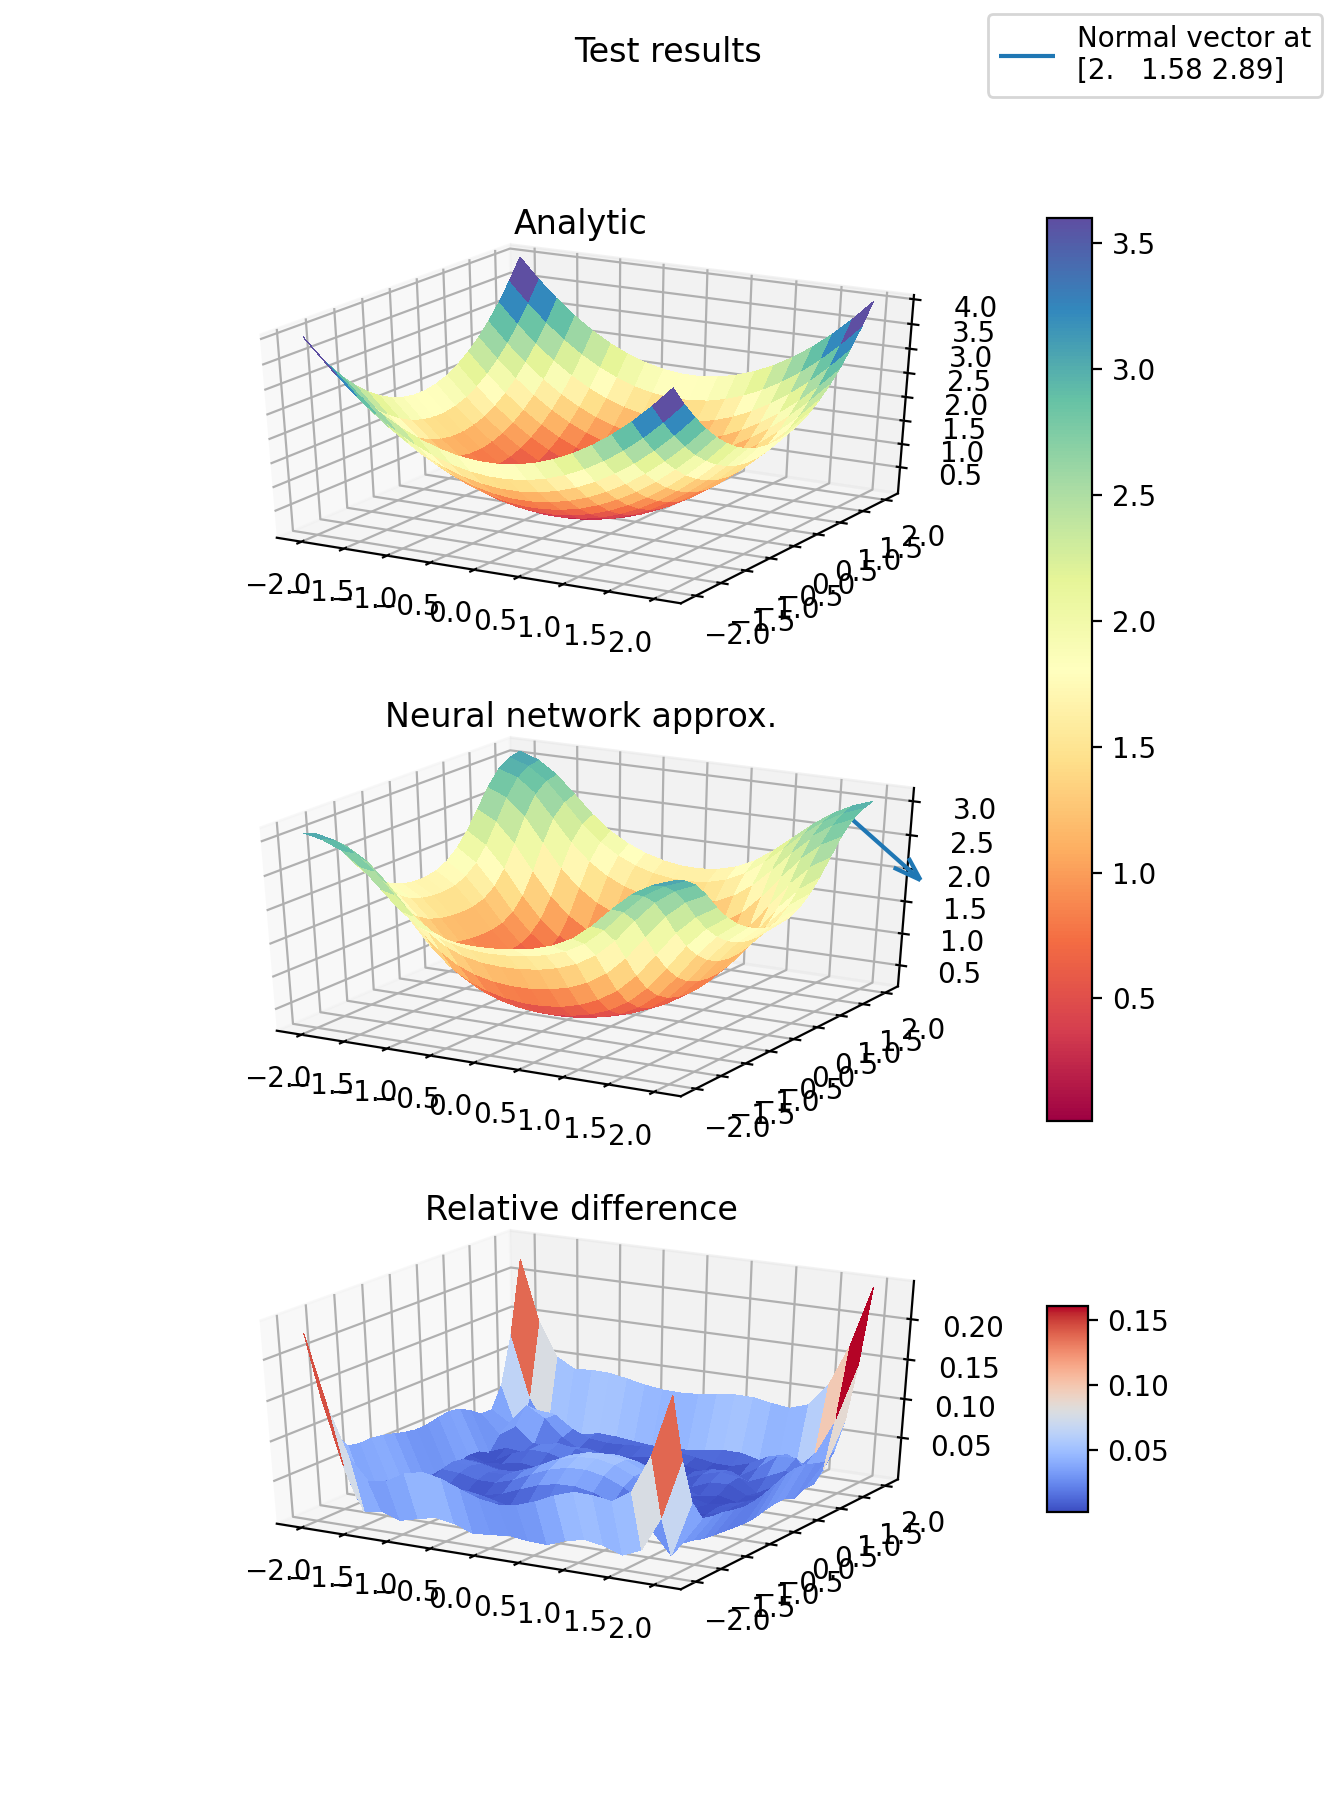

J for test data: 0.01670546936100807


In [27]:
grid = (20,20)
y3 = f3.dom.drawGrid(grid)
c3 = f3(*y3)
test3 = tester(y3, c3, sc3, nn3, f3, grid = grid)
test3.plot()

Training: Done     Runtime: 17.89 seconds                     


<IPython.core.display.Javascript object>


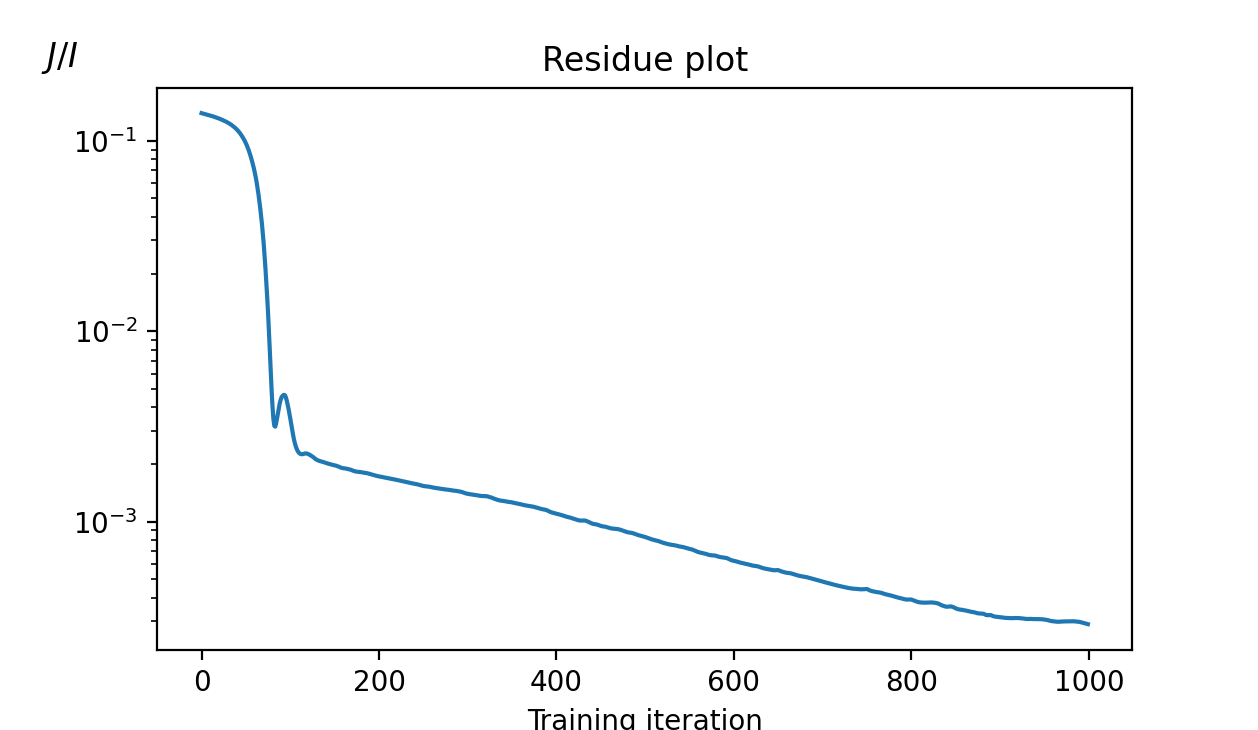

Last J from training:  0.0002900045937649805


<IPython.core.display.Javascript object>


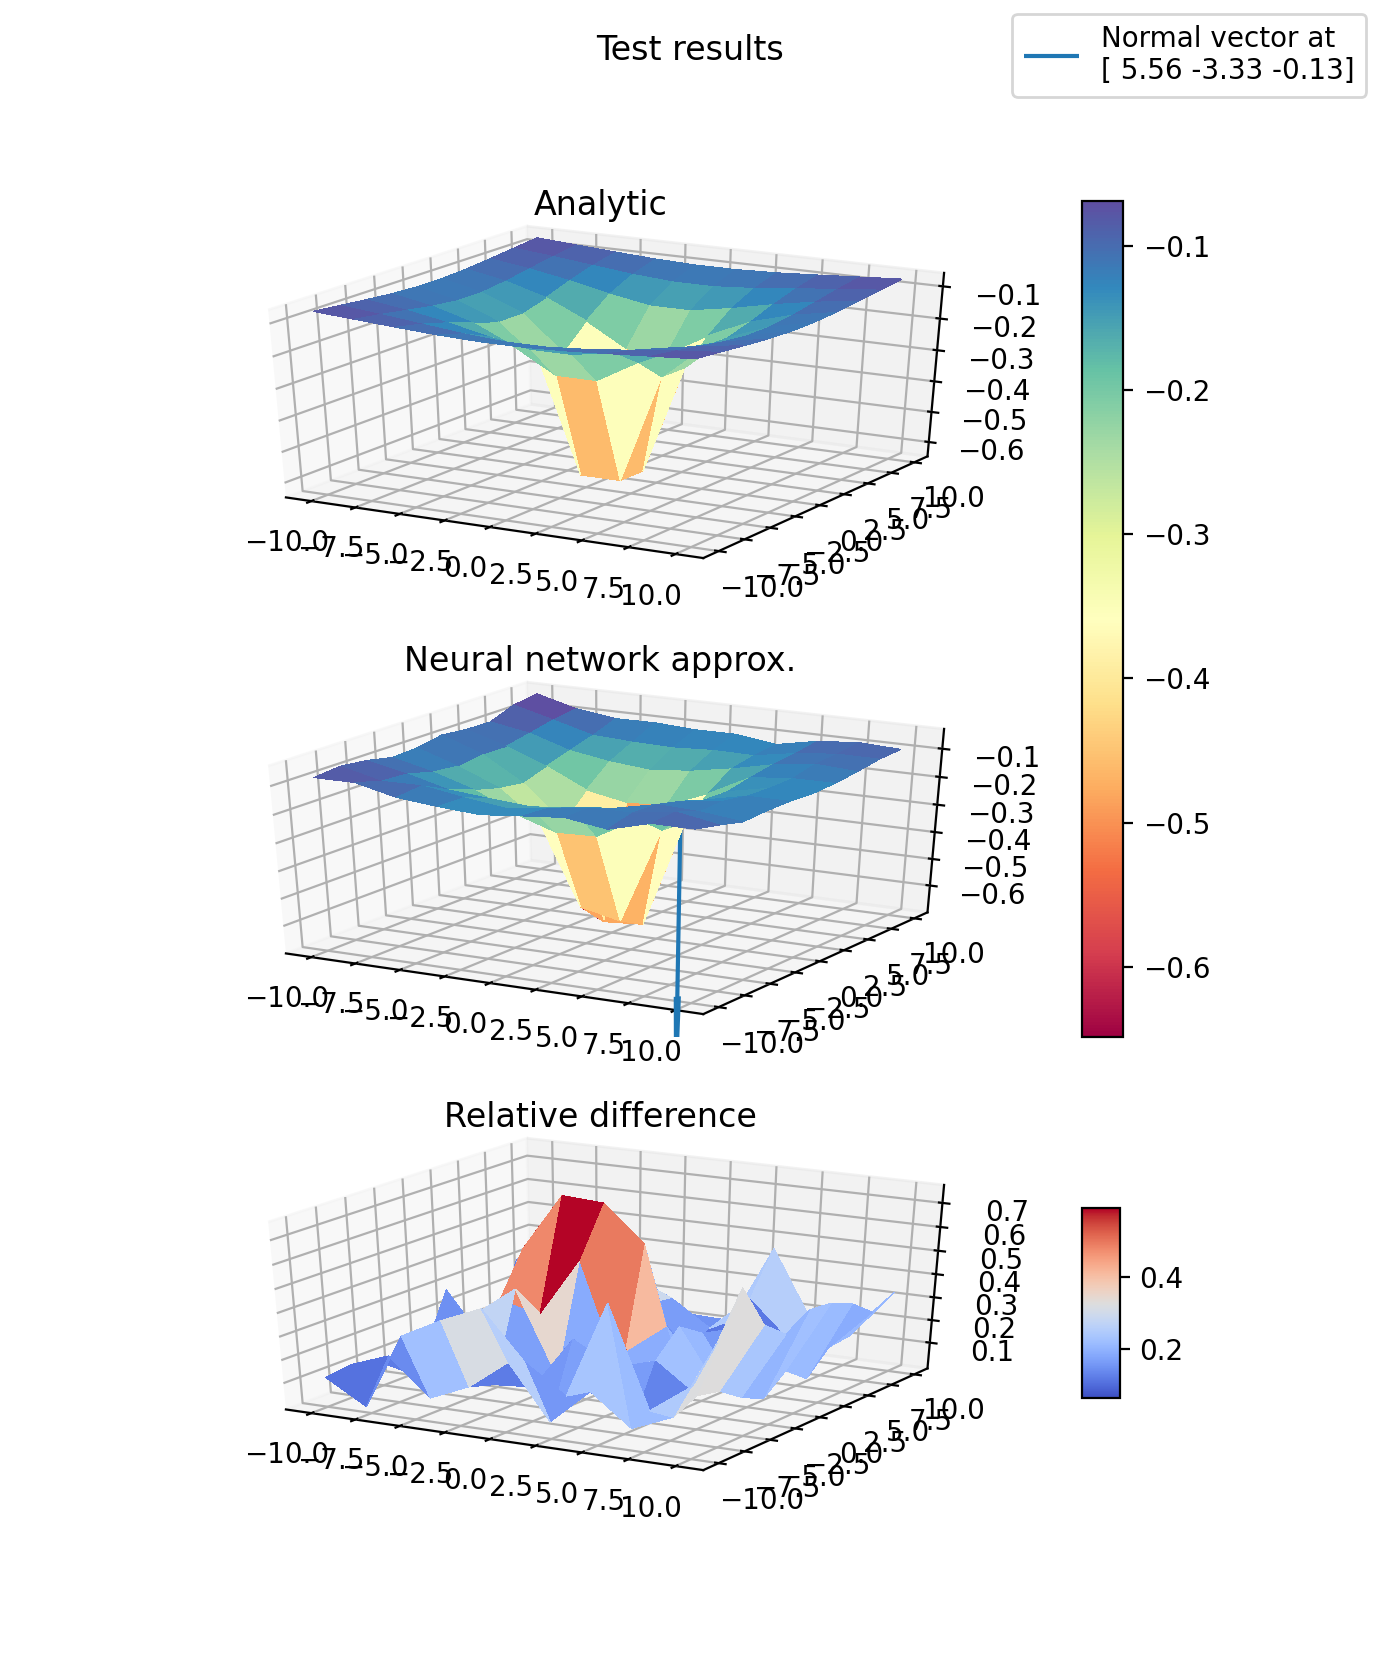

J for test data: 0.00020822897538426766


In [28]:
#__________ f4(y) __________

sc4, y4, c4 = genData(f4, 800)

nn4 = network(K = 30, 
            tau = 0.001,
            h = 0.01,
            d = 4,
            d0 = 2,
            iterations = 1000
            )

nn4.train(y4, c4, 20)

grid = (10,10)
y4 = f4.dom.drawGrid(grid)
c4 = f4(*y4)
test4 = tester(y4, c4, sc4, nn4, f4, grid = grid)
test4.plot()

**Remarks to $F_3(y)$ and $F_4(y)$:** Functions $F_3(y)$ and $F_4(y)$ are of dimensions $d_0=2$ are far more
complex than one-dimensional polynomials of degree $2$. Therefore, it seemed necessary to use more
precise parameters, and by systematic testing, $h$ is changed from $0.1$ to $0.01$, the number of
data points is increased from $200$ to $800$, and number of iterations incresed from $600$ to $1,000$.
Also note that for $d_0=2$, by the rule of thumb, the number of sample points ought to be at least $Kd^2=480$.

It is worth noting that in $F_3(y)$, $J$ is of order $10^{-3}$ for testing, but of order $10^{-5}$
in the training phase. Such a deviation may suggest a case of overfitting. However, by analyzing the surface plots,
the network seem to approximate the analytical solution very well. The surface plot of the differences indicate
that the error is mainly in the outer corners of the function domain. The difference in $J$ when comparing test value to training value is of degree $10^1$, and thus not overfitted.

The resulting plots show that $\tilde{F}(y;\theta)$ seemingly fit the same shape in both two-dimensional cases.

#### 2.5.2 - Testing and training on trajectory data
We define a function `genTrajData` to import the trajectory data in the same manner as
`genData` does, including necessary scaling. The function allows for two main methods to import the trajectory data;

The first method imports all data from a specified `batch`, which is `0` by default.
The second method stochastically chooses `I` data points to include, within batch \[`batchMin`, `batchMax`].

In the two following cells, we train a new network on random trajectory data (using concatenate), and test the network.

In [29]:
def genTrajData(hamParam, I=None, batch=0, batchMin=0, batchMax=50):
    '''
    Generates data in same manner as genData, including nececcary scaling, with trajectory data
    Inputs:
    hamParam : The hamiltonian we want to import, ie "T" or "V".
    I        : Number of points to generate. If None, the function returns all values from batch parameter
    batch    : Which batch to import data, given I==None
    batchMin : The first batch included in concatenating data
    batchMax : The last batch included in concatenating data
    '''
    if hamParam=="T":
        pq="P"
    elif hamParam=="V":
        pq="Q"
    else:
        raise Exception("Hamiltonian must be V or T.")
    
    if I != None:
        datDict = dataFile.concatenate(batchMin, batchMax)
    else:
        datDict = dataFile.generate_data(batch)
    c = datDict[hamParam]
    y = datDict[pq]

    # Select a random subset of all the trajectory data
    if I != None:
        selected = np.random.default_rng().choice(y.shape[1], I, replace=False)
        c = c[selected]
        y = y.T[selected].T

    sc_c = scaler(c)
    sc_y = scaler(y)
    return sc_c, y, sc_c.scale(c)

In [30]:
sc_t1, y_t1, c_t1 = genTrajData("T", 2000, batchMin = 0, batchMax = 47)
nn_t1 = network(K = 30, 
            tau = 0.001,
            h = 0.1,
            d = 6,
            d0 = 3,
            iterations = 800
            )

nn_t1.train(y_t1, c_t1, 50)

Training: Done     Runtime: 45.17 seconds                     


<IPython.core.display.Javascript object>


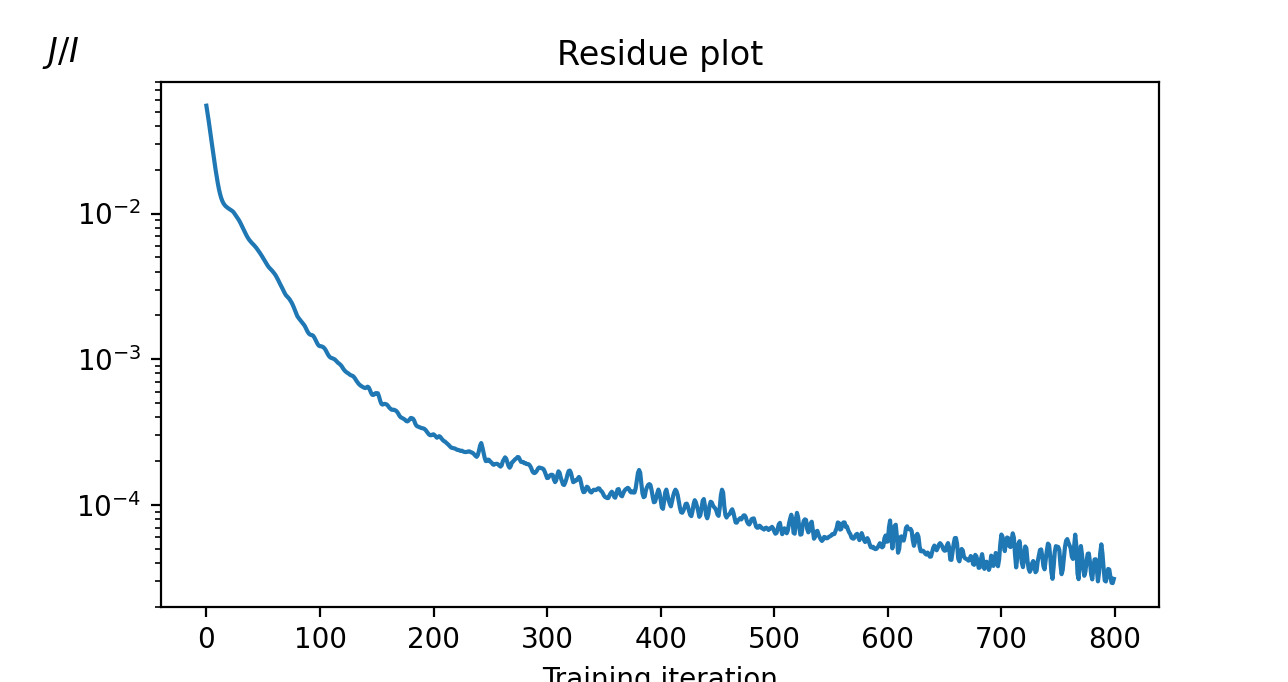

Last J from training:  3.1082478536539027e-05


<IPython.core.display.Javascript object>


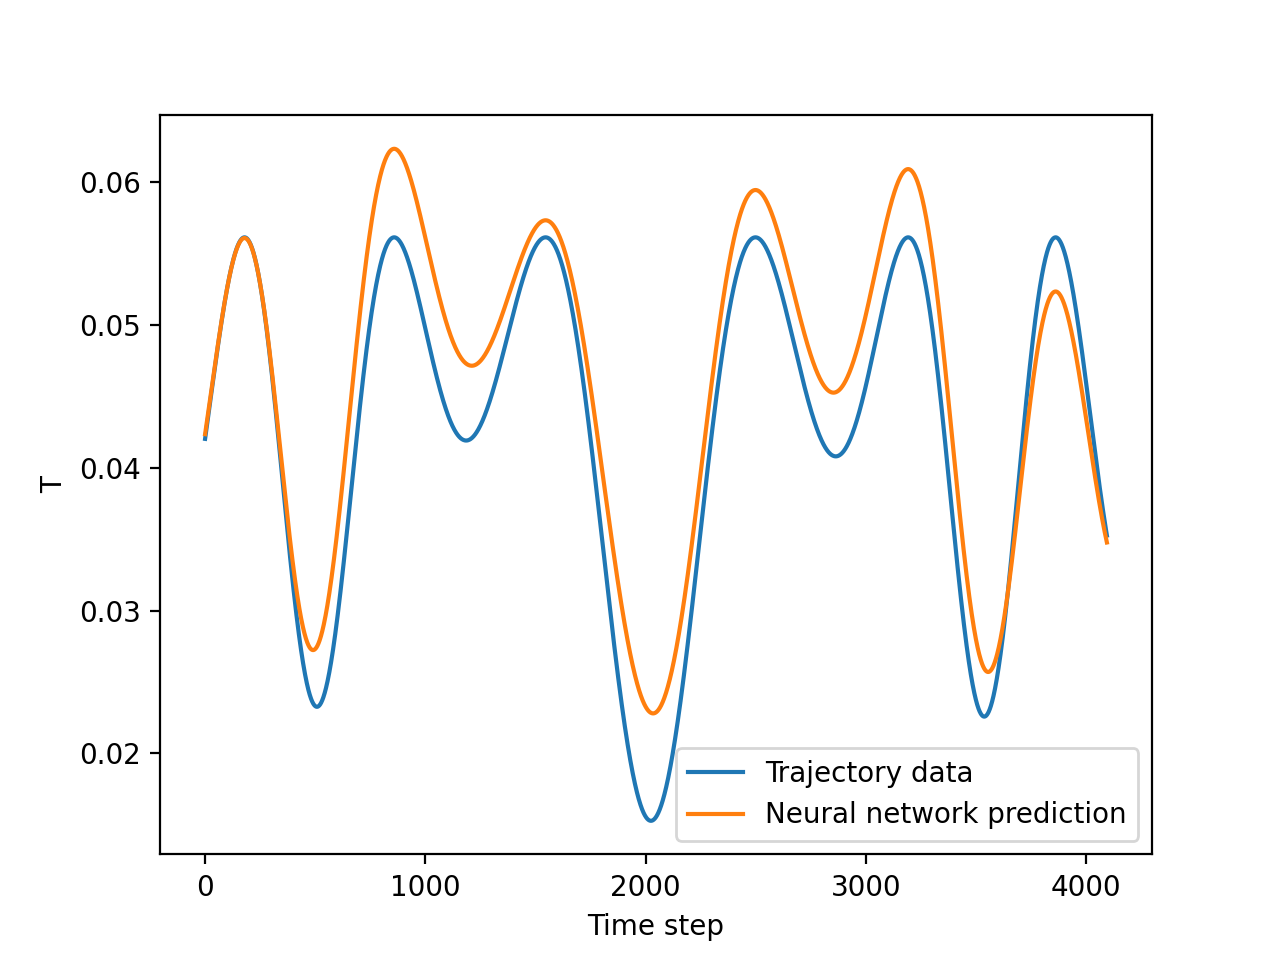

J for test data:  9.549373382183024e-06


In [33]:
sc_t1_test, y_t1_test, c_t1_test = genTrajData("T", batch=49)
c_t1_test = sc_t1_test.rescale(c_t1_test) # We dont want the cs to be scaled, so we rescale them right away

y_t1_test = tuple(y_t1_test)
c_t1_test = c_t1_test

test4 = tester(y_t1_test, c_t1_test, sc_t1, nn_t1, f1)

fig, axs = plt.subplots(1)
test4.trajectoryPlotter(axs, "T")

**Remarks:** $J$ from the test data in this realization is in fact lower than $J$ for the training data.
This is however a small difference, and an artifact of the stochastic nature of training neural networks.
Also note that the network prediction matches the shapes of the trajectory data for $T$ very well.

In *Section 3*, a more in-deph analysis of $H=V+T$ and whether $H$ is preserved, will be discussed.

## Section 3 - Gradient of $F(y)$ and numerical integrators

### 3.1 - Expression for the gradient of $F(y)$
In order to implement numerical integrators for trained neural networks, it is expedient to
derive an expression for $\nabla_y F(y)$, that is, the gradient of the trained function in a point $y$.
<hr>  

For the symplectic Euler and Størmer-Verlet methods, we need an approximation to the gradient of the function that
the neural network approximates. We can write the approximation as the composition of each of the transformations of the neural network. 
We have

$$
F(y) = G \circ \Phi_{K-1}(y_{K-1}) \circ \Phi_{K-2}(y_{K-2}) \circ ... \circ \Phi_0 = G(\Phi(y)),
$$ 

where

$$
\Phi_k(y) = y + h\sigma(W_k y + b_k), \: G(y) = \eta(w^T y + \mu),
$$

which are the maps between each layer and $G(y)$ maps from the final layer into a scalar.
We have all these parameters, so now it has to be made into a computer process so that we can calculate the gradient.
We define 

$$
\Psi_k = \Phi_k \circ \Phi_{k-1} \circ ... \circ \Phi_0, \: k = 1, ..., K-1,
$$

which will be the combined transformations up until the current layer $k$. We now have

$$
F(y) = G(\Psi_{K-1}(y)).
$$

From earlier we have used $Z^{(k)}$ as the input into the $k$th layer, i.e. we have that $Z^{(k)} = \Psi_{k-1}(y), \: k = 1, ..., K.$

Now we try to find the gradient in regards to the input $y$. We use the chain rule an have

$$
\nabla_{y} F(y) = (D\Psi_{K-1}(y))^T \nabla G(Z^{K}).
$$

Now we have tho parts that are unknown to us, $\nabla G(Z^{(K)})$ and $D\Psi_{K-1}(y))^T$.
We have $G$, which can be written as 

$$
G(y) = \eta(\sum_{i = 1}^{d}\omega_i y_i + \mu)
$$

For the jht element of the gradient, we get

$$
\frac{\partial G}{\partial y_j} = \eta '(\sum_{i=1}^{d} \omega_i y_i + \mu)\omega_j = \eta ' (\omega ^T y + \mu)\omega_j
$$

and so the full gradient of $G$ is

$$
\nabla G = \eta '(\omega y + \mu)\omega.
$$

As for $(D\Psi_{K-1}(y))^T$, we can use that the input into the final layer is $Z^{(K)} = \Phi_{K-1} \circ \Psi_{K-2}(y)$.
We have 

$$
D\Psi_{K-1}(y) = D\Phi{K-1}(Z^{(K))}) \cdot D\Psi_{K-2}(y),
$$

and transposed

$$
(D\Psi_{K-1}(y))^T = (D\Psi_{K-2}(y))^T \cdot \left( D\Phi_{K-1}(Z^{(K-1)})\right) ^T
$$


We look at one of the elements of $\Phi(y)$. We can write the $i$th element as

$$
[\Phi(y)]_i = y_i + h\sigma \left(\sum_{j=1}^d W_{ij}y_j + b_i \right).
$$

We then differentiate it, we have

$$
\frac{\partial \Phi_i}{\partial y_r} = \delta_{ir} + h \sigma '\left( \sum_{j=1}^{d} W_{ij} y_j + b_i \right) W_{ir}
$$

For a vector $A$, we need to calculate $(D\Phi(y))^T A$, where the $r$th component is

$$
\sum_{i=1}^{d}[D\Phi(y)]_{ir}A_i = A_r + h \sum_{i=1}^{d}\sigma ' \left(\sum_{j=1}^{d} W_{ij} y_j + b_i \right) W_{ir} A_i 
$$


Considering the last term as a Hadamard product, we can then finally find

$$
D\Phi(y)^T A = A + W^T (h \sigma ' (Wy + b) \odot A).
$$

<hr>

An implementation of this method is relatively straight-forward.
See the definition of the member function `grad` inside the `network` class for details.

### 3.2 - The symplectic Euler and Størmer-Verlet methods 
The section will cover implementation and testing of two symplectic integrators, namely the symplectic Euler
and the Størmer-Verlet method. These methods can then be used on both known and unknown Hamiltonians.

The symplectic Euler method is as follows
$$
\begin{matrix}
q_{n+1}=q_n+h \frac{\partial T}{\partial p}(p_n) \\
 \\
p_{n+1}=p_n-h \frac{\partial V}{\partial q}(q_{n+1}),
\end{matrix}
$$


and the Størmer-Verlet method is given by
$$
\begin{matrix}
p_{n+\frac12}=p_n-\frac{\Delta t}{2}\frac{\partial V}{\partial q}(q_n) \\
 \\
q_{n+1}=q_n+\Delta t\frac{\partial T}{\partial p}(p_{n+\frac12}) \\
 \\
p_{n+1}=p_{n+\frac12}-\frac{\Delta t}{2}\frac{\partial V}{\partial q}(q_{n+1}).
\end{matrix}
$$

Before testing the methods on an unkonwn Hamiltonian, we test on known separable Hamiltonians,
namely for a non-linear pendulum, for the Kepler Two-Body problem and the The Henon-Heiles problem,
all of which are separable. For practical purposes, the problems are listed below.

* **Non-linear pendulum** $H(p,q)=\frac12 p^2 + mgl(1-\cos(q)), \quad p, q \in \mathbb{F}$, 
* **Kepler two-body problem** $H(\mathbf{p},\mathbf{q})=\frac12 \mathbf{p}^T\mathbf{p} -\frac{1}{\sqrt{q_1^2+q_2^2}}$
* **Henon-Heiles problem** $H(\mathbf{p},\mathbf{q})=\frac12 \mathbf{p}^T\mathbf{p}+\frac12 \mathbf{q}^T\mathbf{q}+q_1^2 q_2-\frac13 q_2^3$

where $\mathbb{F}$ is the scalar field, i.e. $\mathbb{F}=\mathbb{R} \text{ or } \mathbb{C}$.


### 3.3 - Implementation of numerical integrators and known hamiltonians

The following cell contains the implementation of said methods and known hamiltonians using the infrastructure from the syntethic functions in *Section 1*. In addition, we define `testNumIntKnown` and `plotTotalEnergy`. `testNumIntKnown` is a function that trains necessary networks, runs both methods on the networks, and compares the difference between the methods.

`plotTotalEnergy` aims to plot the total energy, $T+V$, over time steps to determine if the Hamiltonian is preserved. 


In [34]:
def numIntInit(N, T, y0, nn):
    '''Helper function that initalizes containers used in both integrators'''
    p = np.zeros((N+1, nn.d0))
    q = np.zeros((N+1, nn.d0))
    p[0] = y0[0]
    q[0] = y0[1]
    h = T / N #\Delta t
    return p, q, h

def sympEuler(sc_V, sc_T, nn_V, nn_T, y0, N, T):
    '''Symplectic Euler method
    Input: 
        nn_V : trained network object for H(q)
        nn_T : trained network object for T(p)
        y0=[p0, q0]
        N=number of steps,
        T, last time step,
    Output:
        p, q: Numpy-array with values for "p"/"q", with the index matching their appropriate time step.
    '''
    # Initialize containers
    p, q, h = numIntInit(N, T, y0, nn_V)
    
    for n in range(N): #Perform steps with symplectic euler method
        #The following lines are an implementation with gradient rescaling enabled. See discussion below
        q[n+1] = q[n] + h*np.squeeze(sc_T.gradientRescale(nn_T.grad(np.array([p[n]]).T))) #q_n+1 = q_n + h*dTdp(pn)
        p[n+1] = p[n] - h*np.squeeze(sc_V.gradientRescale(nn_V.grad(np.array([q[n+1]]).T))) #p_n+1 = p_n + h*dVdq(q_n+1)
        '''
        q[n+1] = q[n] + h*np.squeeze(nn_T.grad(np.array([p[n]]).T)) #q_n+1 = q_n + h*dTdp(pn)
        p[n+1] = p[n] - h*np.squeeze(nn_V.grad(np.array([q[n+1]]).T)) #p_n+1 = p_n + h*dVdq(q_n+1)
        '''
    return p, q

def stormerVerlet(sc_V, sc_T, nn_V, nn_T, y0, N, T):
    '''Størmer-Verlet method
    Input: 
        nn_V : trained network object for H(q)
        nn_T : trained network object for T(p)
        y0=[p0, q0]
        N=number of steps,
        T, last time step,
    Output:
        p, q: Numpy-array with values for "p"/"q", with the index matching their appropriate time step.
    '''
    p, q, h = numIntInit(N, T, y0, nn_V)
    for n in range(N):
         #The following lines are an implementation with gradient rescaling enabled. See discussion below
        p_n_half = p[n]     - h/2 *sc_V.gradientRescale(nn_V.grad(np.array([q[n]]).T)) #p_mid 
        q[n+1]   = q[n]     + h   *sc_T.gradientRescale(nn_T.grad(np.array([p_n_half]).T))
        p[n+1]   = p_n_half - h/2 *sc_V.gradientRescale(nn_V.grad(np.array([q[n+1]]).T))
        '''
        p_n_half = p[n]     - h/2 *nn_V.grad(np.array([q[n]]).T) #p_mid 
        q[n+1]   = q[n]     + h   *nn_T.grad(np.array([p_n_half]).T)
        p[n+1]   = p_n_half - h/2 *nn_V.grad(np.array([q[n+1]]).T)
        '''
    return p, q
    

def nonLinP(mgl=1):
    '''
    Helper function returning two datGenFunction-objects, for a non-linear pendulum system.
    First variable being for T and other for V.
    '''
    d_nLPT = domain([interval.closed(-2,2)])
    d_nLPV = domain([interval.closed(-np.pi/3,np.pi/3)])
    nonLinPend_T = datGenFunctions(1, 2, lambda p : 0.5*p**2, d_nLPT)
    nonLinPend_V = datGenFunctions(1, 2, lambda q : mgl*(1-np.cos(q)), d_nLPV )
    return nonLinPend_T, nonLinPend_V
def keplerTB():
    '''
    Helper function returning two datGenFunctions for a Kepler Two-body system.
    First variable is for T and the second is for V.
    '''
    d_kTBT = domain([interval.closed(-1,1), interval.closed(-1,1)])
    d_kTBV = domain([interval.closed(-4,4), interval.closed(-4,4)]) - domain([interval.closed(-0.05, 0.05), interval.closed(-0.05, 0.05)])
    keplerTB_T = datGenFunctions(2, 4, lambda p1, p2 : 0.5*np.array([np.inner(p,p) for p in np.array([p1, p2]).T]), d_kTBT)
    keplerTB_V = datGenFunctions(2, 4, lambda q1, q2 : -1/(np.sqrt(q1**2+q2**2)), d_kTBV)
    return keplerTB_T, keplerTB_V

def henonHeiles():
    '''
    Helper function returning two datGenFunctions-objects for a Henon-Heiles system
    First return varaible is for T and second is for V
    '''
    d_hHT = domain([interval.closed(-1,1), interval.closed(-1, 1)]) - domain([interval.closed(-0.1, 0.1), interval.closed(-0.1, 0.1)])
    d_hHV = domain([interval.closed(-0.2,0.2), interval.closed(-0.2, 0.2)]) - domain([interval.closed(-0.1, 0.1), interval.closed(-0.1, 0.1)])
    hHeilesTB_T = datGenFunctions(2, 4, lambda p1, p2 : 0.5*np.array([np.inner(p,p) for p in np.array([p1, p2]).T]), d_hHT)
    hHeilesTB_V = datGenFunctions(2, 4, lambda q1, q2 : 0.5*np.array([np.inner(q,q) for q in np.array([q1, q2]).T]) + q1**2*q2 - 1/3 *q2**3, d_hHV)
    return hHeilesTB_T, hHeilesTB_V




def testNumIntKnown(y0, system, nn_T, nn_V, I, I_bar, N, T):
    '''
    Collection of instructions in order to test the two methods for the known Hamiltonians

    y0:    initial value
    nn_V:  trained network object for H(q)
    nn_T:  trained network object for T(p)
    I:     Number of training data
    I_bar: Number of points for stochastic gradient descent
    N:     number of steps
    T:     last time step


    '''
    system_T, system_V = system()
    # Declare and train new networks

    sc_T, y_T, c_T = genData(system_T, I)
    if not nn_T.hasTrained:
        nn_T.train(y_T, c_T, I_bar)

    sc_V, y_V, c_V = genData(system_V, I)
    if not nn_V.hasTrained:
        nn_V.train(y_V, c_V, I_bar)

    symp_p, symp_q = sympEuler(sc_V, sc_T, nn_V, nn_T, y0, N, T)
    verlet_p, verlet_q = stormerVerlet(sc_V, sc_T, nn_V, nn_T, y0, N, T)

    print("\nDifference in q between the two methods: ", np.linalg.norm(symp_q-verlet_q)/np.product(symp_q.shape))
    print("Difference in p between the two methods: ", np.linalg.norm(symp_p-verlet_p)/np.product(symp_p.shape))

    return symp_p, symp_q, verlet_p, verlet_q, nn_T, nn_V, sc_T, sc_V
    

def plotTotalEnergy(ax, x, p, q, nn_T, nn_V, **kwargs):
    '''
    Plot the total energy of the system against time step

    ax       : axis to plot the total energy into
    p        : series of impulse-data, generated from symplectic Euler or Störmer-Verlet 
    q        : series of positional data, generated from symplectic Euler or Störmer-Verlet
    nn_T     : trained neural network for approximating T(p)
    nn_V     : trained neural network for approximating V(q)
    **kwargs : all further arguments are passed to ax.plot()
    '''


    H = (nn_T + nn_V)(p, q)

    ax.set_ylim(0, 1.1*max(max(np.squeeze(H)), ax.get_ylim()[1]))
    ax.plot(x, np.squeeze(H), **kwargs)
    print(np.std(np.squeeze(H)))







#### 3.3.1 - Applied to nonlinear pendulum

Note that for the following tests, the number of iterations when training the networks, is set to $2,000$.
When only using around $600$ iterations, a lot of the nature of the solutions did not translate
to the approximation properly, such as initial movement from the starting point.

<IPython.core.display.Javascript object>


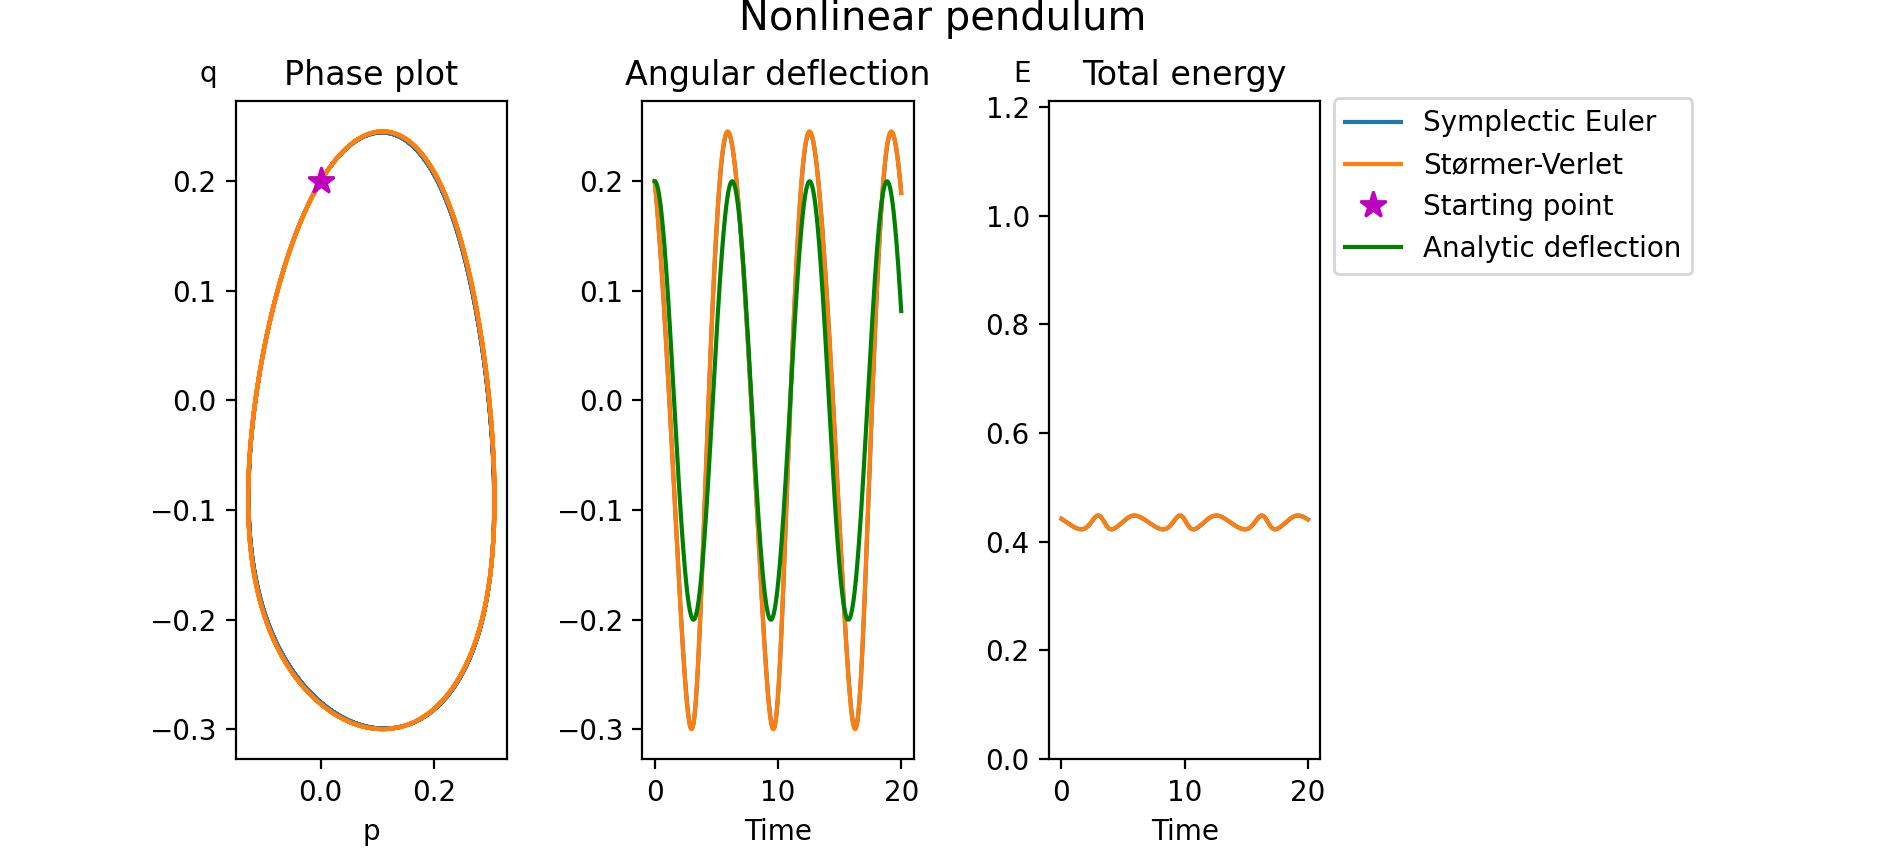


Standard deviation of total energy:
Symplectic Euler: 0.008878949331665678
Størmer-Verlet:   0.008926579108851265


In [47]:
## Step 1 : Create new networks to be trained
nn_T_NL = network(
                K = 30, 
                tau = 0.001,
                h = 0.01,
                d = 2,
                d0 = 1,
                iterations = 2000
                )

nn_V_NL = network(
                K = 30, 
                tau = 0.001,
                h = 0.01,
                d = 2,
                d0 = 1,
                iterations = 2000
                )

N_NL = 1000 #Number of iterations
T_NL = 20 #Time interval [0, T]

## Step 2 : Test numerical integration for non-linear Pendulum
symp_p_NL, symp_q_NL, verlet_p_NL, verlet_q_NL, nn_T_NL, nn_V_NL, sc_T_NL, sc_V_NL = testNumIntKnown(np.array([0,0.2]), nonLinP, nn_T_NL, nn_V_NL, 1500, 20, N_NL, T_NL)


## Step 3 : Presentation of results
fig, ax = plt.subplots(1,3)
### Phase plotting
ax[0].plot(symp_p_NL, symp_q_NL, label="Symplectic Euler") 
ax[0].plot(verlet_p_NL, verlet_q_NL, label="Størmer-Verlet")
ax[0].plot(symp_p_NL[0], symp_q_NL[0], 'm*', label="Starting point", markersize=10)
ax[0].set_xlabel("p")
ax[0].set_ylabel("q", rotation="horizontal")
ax[0].set_title("Phase plot")
ax[0].yaxis.set_label_coords(-0.1,1.02)

### Angular deflection
x_NL = np.linspace(0, T_NL, N_NL+1)
ax[1].plot(x_NL, symp_q_NL)
ax[1].plot(x_NL, verlet_q_NL)
ax[1].plot(x_NL, 0.2*np.cos(x_NL), 'g', label="Analytic deflection") #Hard-coded q_0 = 0.2
ax[1].set_title("Angular deflection")
ax[1].set_xlabel("Time")

### Total energy
ax[2].set_title("Total energy")
ax[2].set_xlabel("Time")
ax[2].yaxis.set_label_coords(-0.1,1.02)
ax[2].set_ylabel("E", rotation='horizontal')

print("\nStandard deviation of total energy:")
print("Symplectic Euler: ",end="")
plotTotalEnergy(ax[2], x_NL, symp_p_NL.T, symp_q_NL.T, nn_T_NL, nn_V_NL)

print("Størmer-Verlet:   ", end="")
plotTotalEnergy(ax[2], x_NL, verlet_p_NL.T, verlet_q_NL.T, nn_T_NL, nn_V_NL)

fig.legend(bbox_to_anchor = (0.7, 0.9), loc="upper left")
plt.suptitle("Nonlinear pendulum", size = "x-large", y = 1)

plt.subplots_adjust(wspace=0.5, right=0.7)
plt.show()



The test is illustrated using three plots; one phase plot for the two methods with a marked starting point.
The second plot shows the angular deflection, i.e. $q(t)$ for the two methods, compared to the analytical solution
$q(t)=q_0 \cos \left(\sqrt{\frac{g}{l}} t \right), \quad q_0 \ll 1$, where $q_0$ is the inital value.
The last plot shows the total energy $H=T+V$ for each time step.

We can see that the angular deflection follows a sine-wave, as to be expected from a pendulum. 
We can also see that the total energy of the system is close constant with periodic anomalies,
and has a standard deviation of order $10^{-3}$.

Based on the last plot, the Hamiltonian seems to be well preserved, with a fairly low standard deviation.

#### 3.3.2 - Applied to the Kepler two-body problem

<IPython.core.display.Javascript object>


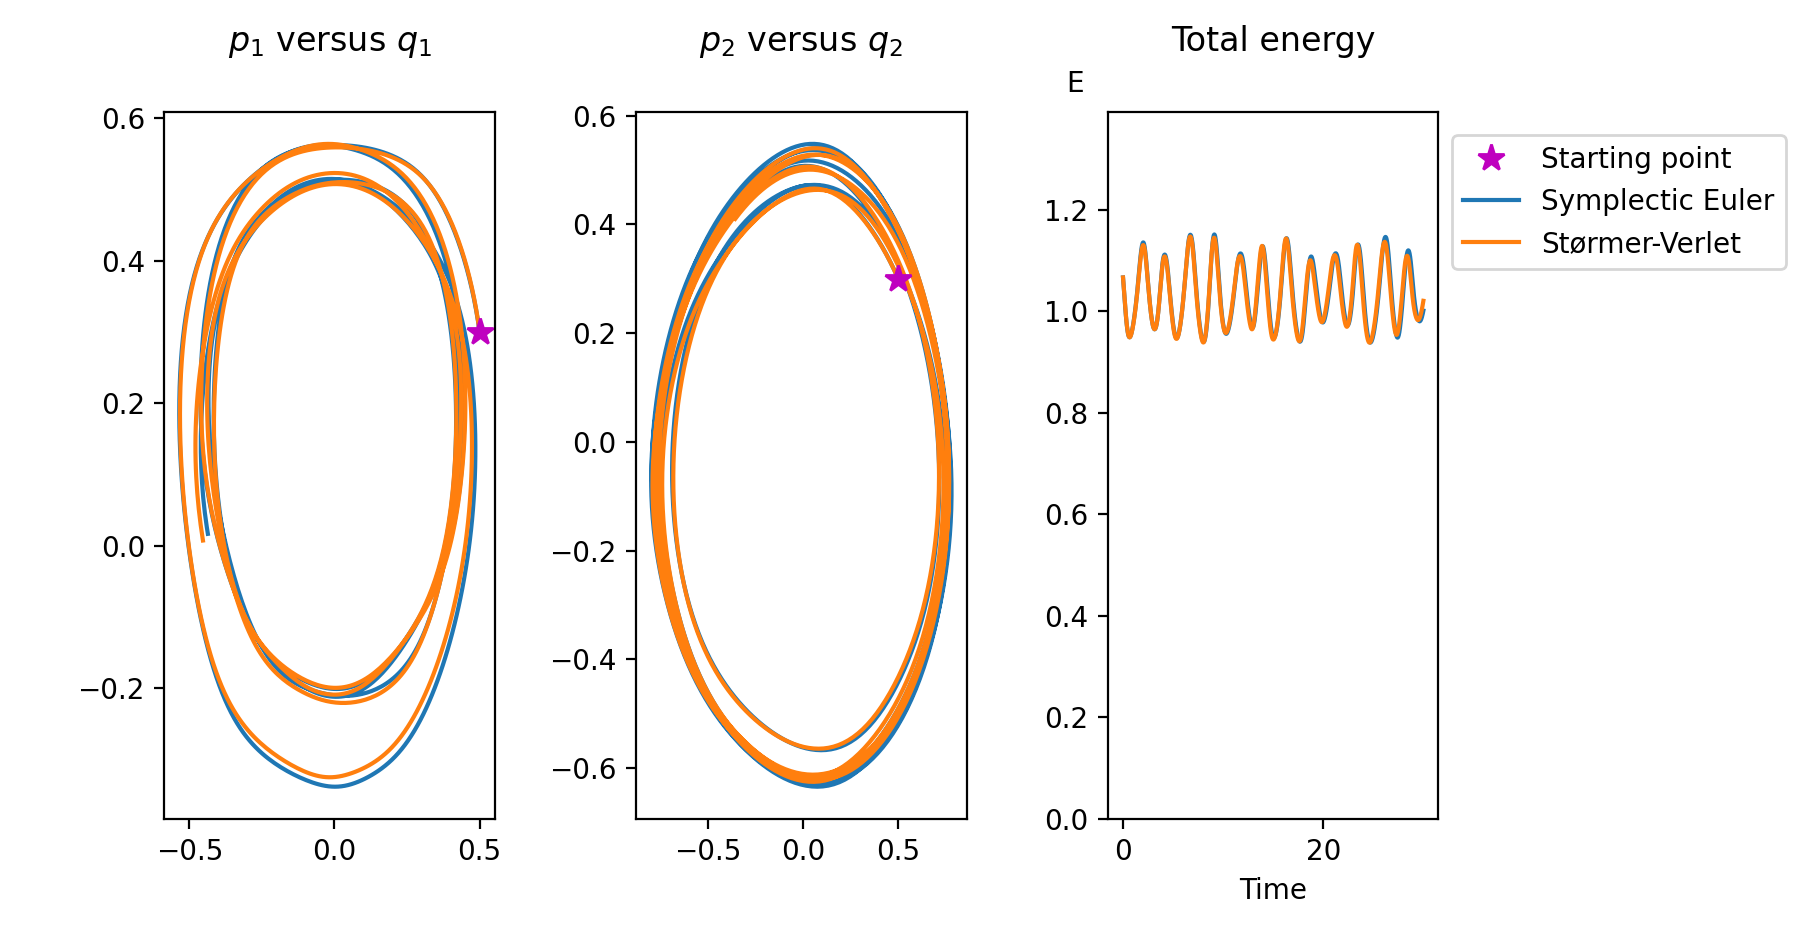


Standard deviation of total energy:
Symplectic Euler: 0.06237039932984198
Størmer-Verlet:   0.060625022748471306


In [61]:
## Step 1 : Create new networks

nn_T_TB = network(
                K = 30, 
                tau = 0.001,
                h = 0.01,
                d = 4,
                d0 = 2,
                iterations = 1000
                )

nn_V_TB = network(
                K = 30, 
                tau = 0.001,
                h = 0.01,
                d = 4,
                d0 = 2,
                iterations = 1000
                )

N_TB = 1000 #Number of iterations
T_TB = 30 #Time interval [0, T]

## Step 2 : Test numerical integration for Kepler two-body problem
symp_p_TB, symp_q_TB, verlet_p_TB, verlet_q_TB, nn_T_TB, nn_V_TB, _, __ = testNumIntKnown(np.array([[0.5,0.5],[0.3,0.3]]), keplerTB, nn_T_TB, nn_V_TB, 1500, 100, N_TB, T_TB)

## Step 3 : Presentation of results
fig, ax = plt.subplots(1, 3)

### Phase plot
x_TB = np.linspace(0, T_TB, N_TB+1)
ax[0].plot(symp_p_TB[:,0], symp_q_TB[:,0])
ax[0].plot(verlet_p_TB[:,0], verlet_q_TB[:,0])
ax[0].set_title("$p_1$ versus $q_1$", pad=22)
ax[0].plot(symp_p_TB[:,0][0], symp_q_TB[:,0][0], 'm*', label="Starting point", markersize=10)

ax[1].plot(symp_p_TB[:,1], symp_q_TB[:,1]) #p1 vs. q1
ax[1].plot(verlet_p_TB[:,1], verlet_q_TB[:,1]) #p2 vs. q2
ax[1].set_title("$p_2$ versus $q_2$", pad=22)
ax[1].plot(verlet_p_TB[:,1][0], verlet_q_TB[:,1][0], 'm*', markersize=10)




### Total energy
print("\nStandard deviation of total energy:")
print("Symplectic Euler: ",end="")
plotTotalEnergy(ax[2], x_TB, symp_p_TB.T, symp_q_TB.T, nn_T_TB, nn_V_TB, label="Symplectic Euler")
print("Størmer-Verlet:   ", end="")
plotTotalEnergy(ax[2], x_TB, verlet_p_TB.T, verlet_q_TB.T, nn_T_TB, nn_V_TB, label="Størmer-Verlet")
fig.legend(bbox_to_anchor=(0.8, 0.87), loc="upper left")
ax[2].set_title("Total energy", pad=22)
ax[2].set_xlabel("Time")
ax[2].yaxis.set_label_coords(-0.1,1.02)
ax[2].set_ylabel("E", rotation="horizontal")
fig.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()

In the Kepler two-body problem, $p$ and $q$ are both two-dimensional, so it is a bit harder to visualize.
The phase plots between their dimensions seem to be closed, which is desirable. 

The total energy follows the same periodic pattern like in the case of nonlinear pendulum,
but with significantly higher amplitudes. Changing the inital values would reduce this amplitude,
but in return also destabilize the phase plots. Regardless, the total energy fluctuates over a constant value,
namely the equilibrium of the function corresponding to $H$. Thus we may conclude that the Hamiltonian is preserved. 

#### 3.3.3 - Applied to the Henon-Heiles problem 

<IPython.core.display.Javascript object>


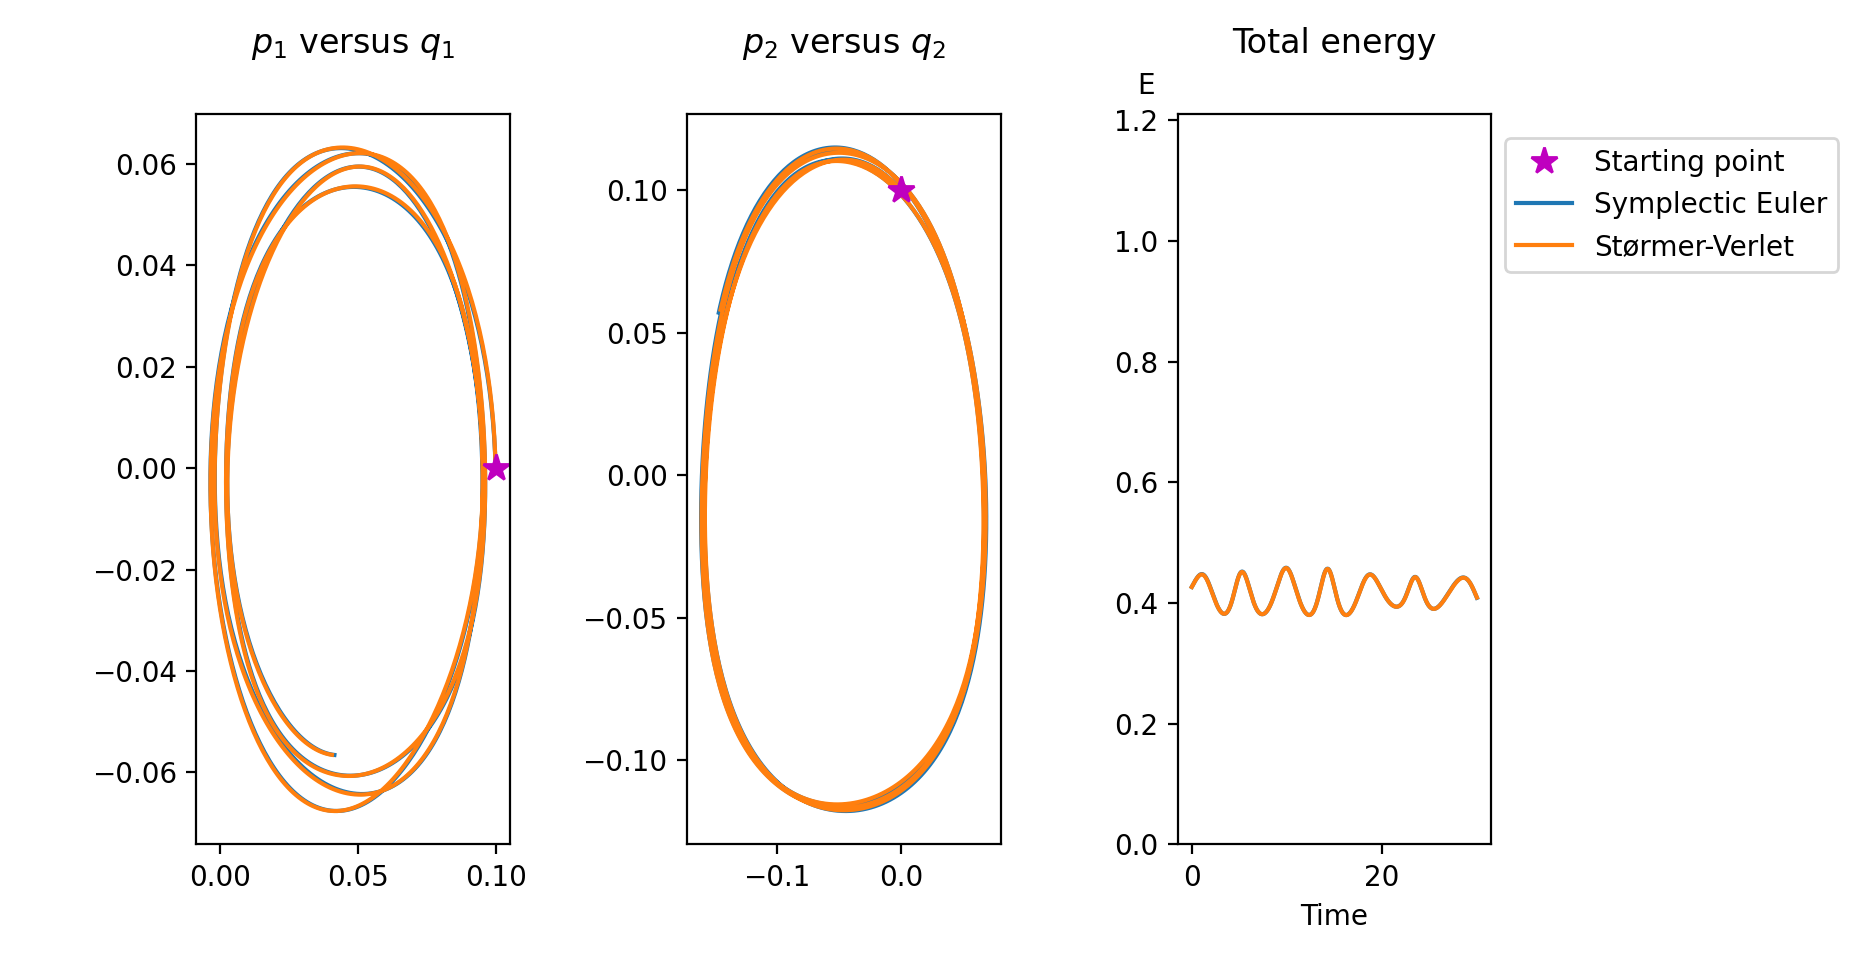


Standard deviation of total energy:
Symplectic Euler: 0.023273284196314047
Størmer-Verlet:   0.023116271853752646


In [64]:
## Step 1 : Create new networks
nn_T_HH = network(
                K = 30, 
                tau = 0.001,
                h = 0.01,
                d = 4,
                d0 = 2,
                iterations = 2000
                )

nn_V_HH = network(
                K = 30, 
                tau = 0.001,
                h = 0.01,
                d = 4,
                d0 = 2,
                iterations = 2000
                )

N_HH = 1000 #Number of iterations
T_HH = 30 #Time interval [0, T]

## Step 2 : Test numerical integration for Kepler two-body problem
symp_p_HH, symp_q_HH, verlet_p_HH, verlet_q_HH, nn_T_HH, nn_V_HH, _, __ = testNumIntKnown(np.array([[0.1,0],[0,0.1]]), henonHeiles, nn_T_HH, nn_V_HH, 1500, 20, N_HH, T_HH)

## Step 3 : Presentation of results
x_HH = np.linspace(0, T_TB, N_TB+1)

fig, ax = plt.subplots(1, 3)
ax[0].plot(symp_p_HH[:,0], symp_q_HH[:,0])
ax[0].plot(verlet_p_HH[:,0], verlet_q_HH[:,0])
ax[0].set_title("$p_1$ versus $q_1$", pad = 22)
ax[0].plot(symp_p_HH[:,0][0], symp_q_HH[:,0][0], 'm*', label="Starting point", markersize=10)


ax[1].plot(symp_p_HH[:,1], symp_q_HH[:,1])
ax[1].plot(verlet_p_HH[:,1], verlet_q_HH[:,1])
ax[1].set_title("$p_2$ versus $q_2$", pad = 22)
ax[1].plot(symp_p_HH[:,1][0], symp_q_HH[:,1][0], 'm*', markersize=10)


print("\nStandard deviation of total energy:")
print("Symplectic Euler: ",end="")
plotTotalEnergy(ax[2], x_HH, symp_p_HH.T, symp_q_HH.T, nn_T_HH, nn_V_HH, label="Symplectic Euler")
print("Størmer-Verlet:   ", end="")
plotTotalEnergy(ax[2], x_HH, verlet_p_HH.T, verlet_q_HH.T, nn_T_HH, nn_V_HH, label="Størmer-Verlet")
fig.legend(bbox_to_anchor=(0.8, 0.87), loc="upper left")
ax[2].set_title("Total energy", pad = 22)
ax[2].yaxis.set_label_coords(-0.1,1.02)
ax[2].set_ylabel("E", rotation="horizontal")
ax[2].set_xlabel("Time")
fig.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()

The phase plots indicate a closed loop, but the total energy seem to differ more than for the two other problem.
This may be attributed to the chaotic behavior of the Henon-Heiles problem, but this should not be impactful until
$H(p^{(0)},q^{(0)}) > \frac16$ and $T(p^{(0)}) > \frac16$, which is not the case when using the initial values $p^{(0)}=[0.1, 0], q^{(0)}=[0,0.1]$.
<hr>

**General remarks for the known hamiltonians**

For all three problems, the two different methods yielded very similar results with differences only around $10^{-5}$.
The phase plots for the three models also follows a circular pattern, which is to be expected by the
symplectic nature of the methods.

From the testing phase, it is quite clear that the systems are highly sensitive to the given inital values.
Small changes in the initial values will produce a big difference in the plots. 

Another issue worth noting is the unexpected behavior of the total energy plots. For nonlinear pendulum and
Kepler two-body problem, we observe a somewhat periodic deviation from a constant value.
For the Henon-Heiles problem, the amplitudes are not constant along all time steps.
The sources of this behavior is uncertain, although it may be from the chaotic nature of the inital values.

### 3.4 - Numerical integrators applied to the unkown Hamiltonian

Applying the two methods to an unknown Hamiltonian is similar to applying them to known Hamiltonians.
We define a closely similar function, `testNumIntUnknown`, that generates $I$ data points,
and caluclates $p$ and $q$ using the two numerical methods.

<IPython.core.display.Javascript object>


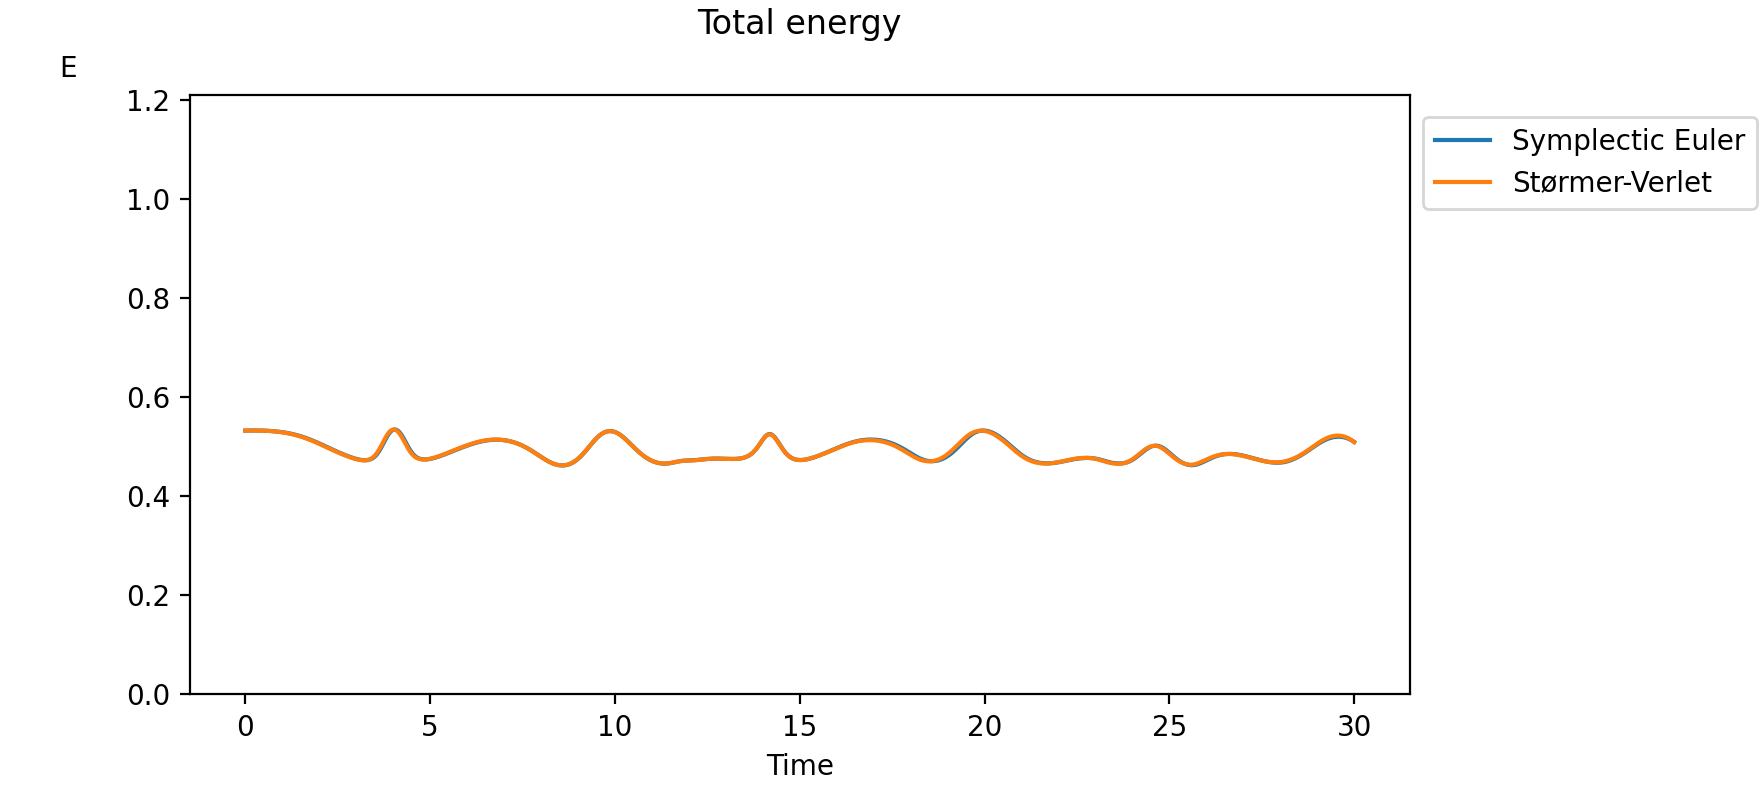


Standard deviation of total energy:
Symplectic Euler: 0.02077699857450407
Størmer-Verlet:   0.02075028761369274


In [66]:
def testNumIntUnknown(nn_T, nn_V, I, I_bar, N, T, y0=None): 
    '''Function for generating data to train/test, and calculating p/q using the two methods.
    Input:
        nn_T : Neural network for T
        nn_V : Neural network for V
        I    : Number of points to be generated
        I_bar: Number of points for stochastic gradient descent
        N    : Number of steps in the numerical integrators
        T    : Time interval for numerical integrators, [0,T]
        y0   : Optional, inital values, here calculated as the average of p_i / q_i
    '''
    sc_t, y_t, c_t = genTrajData("T", I, batchMin=0, batchMax=47)
    if not nn_T.hasTrained:
        nn_T.train(y_t, c_t, I_bar)

    avg_p = np.average(y_t, axis=1)

    sc_v, y_v, c_v = genTrajData("V", I, batchMin=0, batchMax=47)
    if not nn_V.hasTrained:
        nn_V.train(y_v, c_v, I_bar)

    avg_q = np.average(y_v, axis=1)

    if y0 == None:
        y0 = np.array([avg_p, avg_q])

    symp_p, symp_q = sympEuler(sc_v, sc_t, nn_V, nn_T, y0, N, T)
    verlet_p, verlet_q = stormerVerlet(sc_v, sc_t, nn_V, nn_T, y0, N, T)

    print("\nDifference in q between the two methods: ", np.linalg.norm(symp_q-verlet_q)/np.product(symp_q.shape))
    print("\nDifference in p between the two methods: ", np.linalg.norm(symp_p-verlet_p)/np.product(symp_p.shape))

    return symp_p, symp_q, verlet_p, verlet_q, nn_T, nn_V, sc_t, sc_v

## Part 1 : Create and train new networks
nn_T_UH = network(
    K = 30, 
    tau = 0.001,
    h = 0.1,
    d = 2*3,
    d0 = 3,
    iterations = 800
    )
nn_V_UH = network(
    K = 30,
    tau = 0.001,
    h = 0.1,
    d = 2*3,
    d0 = 3,
    iterations = 800
    )

T_UH = 30
N_UH = 1000



sp, sq, vp, vq, nnT, nnV, _, __ = testNumIntUnknown(nn_T_UH, nn_V_UH, 1000, 100, N_UH, T_UH)

fig, ax = plt.subplots(1)
x_UH = np.linspace(0, T_UH, N_UH+1)

ax.set_title("Total energy", pad=22)

print("\nStandard deviation of total energy:")
print("Symplectic Euler: ",end="")
plotTotalEnergy(ax, x_UH, sp.T, sq.T, nnT, nnV,  label="Symplectic Euler")

print("Størmer-Verlet:   ", end="")
plotTotalEnergy(ax, x_UH, vp.T, vq.T, nnT, nnV, label="Størmer-Verlet")

ax.set_xlabel("Time")
ax.yaxis.set_label_coords(-0.1,1.02)
ax.set_ylabel("E", rotation="horizontal")

fig.legend(bbox_to_anchor=(0.8, 0.87), loc="upper left")

fig.tight_layout()
plt.subplots_adjust(right=0.8)

plt.show()



The initial values for the unknown Hamiltonian is the average of all randomly selected values.

We observe that also for the unknown Hamiltonian, the total energy is seemingly conserved - the curve has similar properties to
the known problems, but with an even smaller periodic deviation.

## Conclusion

The first section implements synthetic functions that come in handy when generating data for testing the algorithms.
The second section implements the machine learning algorithm using the Adam-algorithm with a stochastic
gradient descent.
The third section derives the gradient of the network-trained function, as well as
implementation of two numerical integrators (symplectic Euler and Størmer-Verlet) for trained networks, both
trained on known Hamiltonians and unknown Hamiltonians.

Section 1 and 2 provides sufficients results, indicating that the neural network implementation works as intended.
Furthermore, it seems possible to approximate the Hamiltonians with the use of machine learning.
The approximations naturally differ to some degree, and due to the stochastic nature og machine learning,
the results unfortunately diverse with some runs. Testing indicates however that
the plots converge more often than not.

One noteworthy discovery is that the systems are highly sensitive to the given inital values.
They have a chaotic behavior, as small changes to the initial values will produce a big difference in the plots. 
They are also sensitive to the value $\bar{I}$, that is, how many points are sampled at once using SGD, considering
the plots diverge when $\bar{I}$ is too small.

We may also observe that the Størmer-Verlet method overall has a lower standard deviation of total energy,
suggesting that this method may be more precise than the symplectic Euler method.